In [ ]:
#Criado por: Vinícius de Almeida Nery Ferreira (ECO - UnB)
#Github: https://github.com/vnery5/Econometria

##Importando os pacotes e módulos necessários
import pandas as pd
import numpy as np
import math

#Para Regressão Linear Simples e Teste F
from scipy import stats

#Para Regressão Linear Múltipla (OLS, GLS e WLS) e Testes Estatísticos
import statsmodels.api as sm

#Para Regressão em Painel e IV
from linearmodels import PanelOLS, FirstDifferenceOLS, PooledOLS, RandomEffects
from linearmodels.panel import compare
from linearmodels.iv import IV2SLS
from statsmodels.iolib.summary2 import summary_col
from stargazer.stargazer import Stargazer

#Pacotes para gráficos (caso precise)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

#Pacotes para fazer a coleta dos dados armazenados no mesmo diretório e outros pacotes gerais
import os
import pathlib
import glob
from IPython.display import clear_output
import gc
import subprocess #permite a cópia para o clipboard das equações gerados com as funções equation()

####################################### Criando as Funções ###############################################################

def coletar_dados(nome = ""):
    '''
    Função que le os arquivos do Stata (.dta) - NÃO COLOQUE A EXTENSÃO NA HORA DE NOMEAR O "NOME"!
    O arquivo deve estar na mesma pasta do arquivo de Python ou do notebook do jupyter.
    Deixe em branco para ler o arquivo mais recentemente adicionado à pasta.
    '''

    global df

    #Pegando qual a pasta do arquivo que está sendo usado pra programar
    caminho = pathlib.Path().absolute()

    #No meu caso específico:
    caminho_vinicius = f"{caminho}/datasets"

    #checando se o nome foi inserido ou não; caso não, pegar o arquivo .dta mais recente
    if nome == "":
        try:
            arquivo = max(glob.glob(f"{str(caminho)}/*.dta"), key=os.path.getctime)
            df = pd.read_stata(arquivo)
            print(f"{arquivo}.dta foi lido com sucesso!")
            return df
        except:
            arquivo = max(glob.glob(f"{str(caminho_vinicius)}/*.dta"), key=os.path.getctime)
            df = pd.read_stata(arquivo)
            print(f"{arquivo}.dta foi lido com sucesso!")
            return df
    else:
        try:
            arquivo = f"{str(caminho)}/{str(nome)}.dta"
            df = pd.read_stata(arquivo)
            print(f"{nome}.dta foi lido com sucesso!")
            return df
        except:
            try:
                arquivo = f"{str(caminho_vinicius)}/{str(nome)}.dta"
                df = pd.read_stata(arquivo)
                print(f"{nome}.dta foi lido com sucesso!")
                return df
            except: #caso não tenha sido encontrado o arquivo com o nome inserido
                print('''
                Não foi possível achar o arquivo :(\n
                Verifique se seu nome está correto (sem a extensão) e se ele está no mesmo diretório do programa!
                ''')

def Regressao_Multipla(x, y, constante = "S", cov = "normal"):
    '''
    Função que calcula uma regressão múltipla, sendo, por default, computada com um intercepto e com erros padrões não robustos.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" ou "clustered" para erros-padrões clusterizados
    '''

    global Resultado, Lista_ychapeu, Resíduos, SQR, EPR

    #adicionando uma constante ao modelo de Ordinary Least Squares (OLS)
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x

    #Criando o Modelo levando em conta a opção de erros padrão
    Modelo = sm.OLS(y,X)

    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'HC1', use_t = True)
    elif cov == "cluster" or cov == "clustered":
        group = str(input("Qual o rótulo da coluna de grupo?"))
        try:
            Resultado = Modelo.fit(cov_type = 'cluster',cov_kwds  ={'groups':df[group]}, use_t = True)
        except:
            erro = "Não foi possível encontrar o grupo selecionado. Tente novamente!"
            return erro
    else:
        Resultado = Modelo.fit()
    
    Lista_ychapeu = Resultado.predict()
    Resíduos = y - Lista_ychapeu

    #Calculando o Erro Padrão da Regressão (EPR)
    SQR =sum([i**2 for i in Resíduos])
    Número_de_Observações = len(y)
    GL = Número_de_Observações - len(Resultado.params)
    VarianciaReg = SQR/GL
    EPR = math.sqrt(VarianciaReg)
    
    ##Printando o Resultado
    print(Resultado.summary())

    print(f"O erro padrão da regressão é {round(EPR,5)} e a SQR é {round(SQR,5)}")
    print("\nPara ver os valores previstos ou os resídudos, basta chamar 'Lista_ychapeu' e 'Resíduos'.")
    print("Os resultados do modelo podem ser obtidos através de métodos usando a variável 'Resultado'.")
    print("""
    Valores de condição maiores que 20 indicam problemas de multicolinearidade.
    Para ver como achar esse número, entre em https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html"""
    )

def Regressao_MQP(x, y, pesos, constante = "S", cov = "normal"):
    '''
    Função que calcula uma regressão múltipla usando mínimos quadrados ponderados, ou seja,
    recomendada quando o erro é heteroscedástico E se sabe a função da constante. Ela é, por default, computada com um intercepto e com erros padrões não robustos.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    pesos: 1/h, sendo h a constante multiplicativa da variância do erro (ou seja, sem a raiz);
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" para erros-padrões clusterizados
    '''

    global Resultado, Lista_ychapeu, Resíduos, SQR, EPR

    #adicionando uma constante ao modelo de Ordinary Least Squares(OLS)
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x

    #Criando o Modelo levando em conta a opção de erros padrão
    Modelo = sm.WLS(y,X, weights = pesos)

    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'HC1', use_t = True)
    elif cov == "cluster" or cov == "clustered":
        group = str(input("Qual o rótulo da coluna de grupo?"))
        try:
            Resultado = Modelo.fit(cov_type = 'cluster',cov_kwds  ={'groups':df[group]}, use_t = True)
        except:
            erro = "Não foi possível encontrar o grupo selecionado. Tente novamente!"
            return erro
    else:
        Resultado = Modelo.fit()

    Lista_ychapeu = Resultado.predict()
    Resíduos = y - Lista_ychapeu

    #Calculando o Erro Padrão da Regressão (EPR)
    SQR =sum([i**2 for i in Resíduos])
    Número_de_Observações = len(y)
    GL = Número_de_Observações - len(Resultado.params)
    VarianciaReg = SQR/GL
    EPR = math.sqrt(VarianciaReg)
    
    ##Printando o Resultado
    print(f"O erro padrão da regressão é {round(EPR,5)} e a SQR é {round(SQR,5)}\n")
    print(Resultado.summary())

    print("\nPara ver os valores previstos ou os resídudos, basta chamar 'Lista_ychapeu' e 'Resíduos'.")
    print("Os resultados do modelo podem ser obtidos através de métodos usando a variável 'Resultado'.")
    print("""
    Valores de condição maiores que 20 indicam problemas de multicolinearidade
    Para ver como achar esse número, entre em https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html"""
    )
    
def Regressao_MQGF(x, y, constante = "S", cov = "normal"):
    '''
    Função que calcula uma regressão múltipla usando mínimos quadrados generalizados factíveis, ou seja,
    recomendada quando o erro é heteroscedástico E NÃO se sabe a função da constante multiplicativa da variância do erro, sendo os pesos estimados
    regridindo o log dos quadrados dos resíduos sobre as variáveis explicativas. Os estimadores MQP são gerados com o peso estimado.
    Ela é, por default, computada com um intercepto e com erros padrões não robustos.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" ou "clustered" para erros-padrões clusterizados
    '''

    global Resultado, Lista_ychapeu, Resíduos, SQR, EPR

    #Regredindo os valores normalmente a fim de pegar os resíduos
    Regressao_Multipla(x,y, constante, cov)
    clear_output()

    #Coletando o log dos quadrados dos resíduos
    Log_Res_Quad = np.log(Resíduos**2)

    #Regredindo Log_Res_Quad sobre as variáveis explicativas
    Regressao_Multipla(x,Log_Res_Quad, constante, cov)
    clear_output()

    #Estimando os pesos
    Pesos = np.exp(Lista_ychapeu)

    #Fazendo uma Regressão MQP
    Regressao_MQP(x,y, 1/Pesos, constante, cov)

def Teste_LM(x, y, Restrições, Nivel_de_Significância = 0.05):
    '''
    Função que calcula um teste LM e dá o resultado teste de hipótese para o caso de todas as restrições serem conjuntamente estatisticamente não-significantes.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    Restrições: lista ou array com os valores a serem tirados do modelo restrito;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''

    ##Definindo as variáveis de cada modelo
    ModeloIrrestrito = list(x)
    ModeloRestrito = []
    Restrições = list(Restrições)

    Numero_de_Observações = len(y)
    GL_r = len(Restrições)

    for i in ModeloIrrestrito:
        if i not in Restrições:
            ModeloRestrito.append(i)
    
    #Fazendo a regressão do modelo restrito e armazenando os resíduos
    Regressao_Multipla(df[ModeloRestrito], y)
    Resíduos_r = Resíduos

    #Fazendo a regressão dos resíduos sobre as variáveis independentes e armazenando o R2
    Regressao_Multipla(x, Resíduos_r)
    Ru = Resultado.rsquared

    #Calculando a estatística LM
    LM = Numero_de_Observações*Ru

    #Calculando o p-valor
    ##Calculando o P-valor de F
    P_valor = stats.chi2.sf(LM,GL_r)

    #Limpando a tela
    clear_output()

    #Printando o resultado
    if Nivel_de_Significância > P_valor:
        print(f"O valor de LM é {round(LM,3)} e seu p-valor é {round(P_valor,7)}. Portanto, rejeita-se Ho a um nível de significância de {Nivel_de_Significância*100}%.")
    else:
        print(f"O valor de LM é {round(LM,3)} e seu p-valor é {round(P_valor,7)}. Portanto, não se rejeita Ho a um nível de significância de {Nivel_de_Significância*100}%.")


def Teste_F(x, y, Restrições, Nivel_de_Significância = 0.05):
    '''
    Função que calcula um teste F e dá o resultado teste de hipótese para o caso de todas as restrições serem conjuntamente estatisticamente não-significantes.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    Restrições: lista ou array com os valores a serem tirados do modelo restrito;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''

    ##Definindo as variáveis de cada modelo
    #para testar igualdade dos coeficientes, F2, p_valueF2 = results.Ftest(['ACT', 'skipped'], equal=True)
    ModeloIrrestrito = list(x)
    ModeloRestrito = []
    Restrições = list(Restrições)

    Numero_de_Observações = len(y)
    GL_ir = Numero_de_Observações - (len(ModeloIrrestrito) + 1)
    GL_r = len(Restrições)

    for i in ModeloIrrestrito:
        if i not in Restrições:
            ModeloRestrito.append(i)

    ##Fazendo as regressões de cada modelo
    Regressao_Multipla(x, y)
    SQR_ir = SQR
    VarianciaReg_ir = EPR**2

    Regressao_Multipla(df[ModeloRestrito], y)
    SQR_r = SQR

    #Limpando a tela
    clear_output()
    
    ##Calculando F
    F = (SQR_r - SQR_ir)/(len(Restrições)*VarianciaReg_ir)

    ##Calculando o P-valor de F
    P_valor = stats.f.sf(F,GL_r,GL_ir)

    if Nivel_de_Significância > P_valor:
        print(f"O valor de F é {round(F,3)} e seu p-valor é {round(P_valor,7)}. Portanto, rejeita-se Ho à significância de {Nivel_de_Significância*100}%.")
    else:
        print(f"O valor de F é {round(F,3)} e seu p-valor é {round(P_valor,7)}. Portanto, não se rejeita Ho à significância de {Nivel_de_Significância*100}%.")

def Teste_F_Rapido_Robusto(H0, Nivel_de_Significância = 0.05):
    '''
    Função que calcula um teste F de forma mais rápida com base nas restrições de H0, podendo ser robusto se o Resultado for fruto de uma regressão robusta.
    H0 deve estar na forma B1 = B2 =...= Valor que deseja ser testado (0 na maioria das vezes)
    '''
    global Resultado
    ## A função utiliza o método wald_test dos resultados das regressões
    # Para modelos de painel - cujo método usa a estatística LM -, devemos especificar o parâmetro 'formula', o que não ocorre com cortes transversais
    try:
        teste = 'LM'
        est = Resultado.wald_test(formula=H0).stat
        p = Resultado.wald_test(formula=H0).pval
    except:
        teste = 'F'
        est = float(str(Resultado.wald_test(H0))[19:29])
        p = float(str(Resultado.wald_test(H0))[36:47])

    if Nivel_de_Significância > p:
        print(f"O valor de {teste} é {round(est,6)} e seu p-valor é {round(p,7)}.\nPortanto, rejeita-se Ho à significância de {Nivel_de_Significância*100}%, ou seja, as variáveis são conjuntamente significantes.")
    else:
        print(f"O valor de {teste} é {round(est,6)} e seu p-valor é {round(p,7)}.\nPortanto, NÃO se rejeita Ho à significância de {Nivel_de_Significância*100}%, ou seja, as variáveis NÃO são conjuntamente significantes.")

def Teste_t_Dois_Coeficientes_Iguais(x, y, Coeficientes_Testados_para_serem_iguais, Nivel_de_Significância = 0.05):
    '''
    Função que executa um teste t para verificar se dois coeficientes são iguais.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    Coeficientes_Testados_para_serem_iguais: array com os valores dos coeficientes que querem ser testados;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''
    
    ##Fazendo a regressão do modelo irrestrito
    Regressao_Multipla(x, y)
    clear_output()

    #Fazendo o objeto de lista que será usado no teste
    Teste =[0]
    Num_de_Variaveis = 1

    for i in list(x):
        if i not in list(Coeficientes_Testados_para_serem_iguais):
            Teste.append(0)
        elif (Num_de_Variaveis % 2 == 0):
            Teste.append(-1)
        else:
            Teste.append(1)
            Num_de_Variaveis += 1

    Teste_t = Resultado.t_test(Teste)
    print(f"A estatística do teste é {Teste_t.tvalue}, o que resulta em um p-valor bilateral de {Teste_t.pvalue} e em um p-valor unilateral de {Teste_t.pvalue/2}.")

def Teste_Heteroscedasticidade_BP(x, y, constante = "S", Nivel_de_Significância = 0.05, Estatística = "LM"):
    '''
    Função que executa o teste de Breusch-Pagan para a heteroscedasticidade.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    Estatística = LM ou F
    '''
    global Resultado 

    #Fazendo a regressão e limpando a tela
    Regressao_Multipla(x,y,constante)
    clear_output()

    #Calculando o quadrado dos resíduos
    Res_Quad = Resíduos**2

    #Realizando o teste F ou LM de Res_Quad sobre as variaveis dependentes para ver se há correlação
    if Estatística == "LM":
        Teste_LM(x, Res_Quad, x, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")
    else:
        Teste_F(x, Res_Quad, x, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")

def Teste_Heteroscedasticidade_White(modelo, constante = "S", Nivel_de_Significância = 0.05, Estatística = "LM"):
    '''
    Função que executa o teste de White (modificado por Wooldridge) para a heteroscedasticidade.

    modelo: objeto do fit
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    Estatística: LM ou F
    '''
    global Resultado

    ## Calculando o quadrado dos resíduos
    try: # para objetos do sm
        Res_Quad = Resultado.resid**2
    except Exception: # para objetos do linearmodels
        Res_Quad = Resultado.resids**2

    #Calculando o quadrado dos valores previstos
    Previstos = Resultado.predict()
    Previstos2 = Previstos**2

    #Criando um dataframe pra armazenar esses valores
    dfy_y2 = pd.DataFrame({"y":Previstos,"y2":Previstos2})
    y_y2 = dfy_y2[['y','y2']]

    #Realizando o teste F ou LM de Res_Quad sobre y e y^2
    if Estatística == "LM":
        Teste_LM(y_y2, Res_Quad, y_y2, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")
    else:
        Teste_F(y_y2, Res_Quad, y_y2, Nivel_de_Significância)
        print("Ho: O erro é homoscedástico")

def RESET(x, y, constante = "S", robusta = "N", Nivel_de_Significância = 0.05):
    '''
    Função que executa um teste RESET para verificar a adequação das formas funcionais.
    Ho: o modelo está bem especificado.

    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''
    #Fazendo uma regressão múltipla e limpando a tela
    Regressao_Multipla(x, y, constante)
    clear_output()

    #Verificando o tipo da covariância selecionada
    if robusta == "N":
        tipo = 'nonrobust'
    else:
        tipo = 'HC1'

    Teste = sm.stats.diagnostic.linear_reset(Resultado, power = 2, use_f = False, cov_type = tipo)
    
    if Teste.pvalue < Nivel_de_Significância:
        print(f"""
        O p-valor do teste foi de {np.around(Teste.pvalue,6)}, menor que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, rejeita-se Ho (o modelo está MAL especificado)."""
        )
    else:
        print(f"""
        O p-valor do teste foi de {np.around(Teste.pvalue,6)}, maior que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, não se rejeita Ho (o modelo NÃO está MAL especificado)"""
        )

def Teste_J_Davidson_MacKinnon(x1,x2, y, constante = "S", robusta = "N", Nivel_de_Significância = 0.05):
    '''
    Função que executa um teste J para verificar qual o modelo mais adequado (dentre os dois colocados).
    Ho: o modelo 1 é preferível (ver o p-valor do último coeficiente).

    x1: lista ou array com os valores das variáveis independentes do primeiro modelo;
    x2: lista ou array com os valores das variáveis independentes do segundo modelo;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão comuns;
    Nivel_de_Significância: nível de significância do teste. Caso branco, o nível de significancia padrão é de 5%.
    '''
    
    #Fazendo a regressão do segundo modelo
    Regressao_Multipla(x2, y, constante, robusta)
    clear_output()

    #Criando um novo dataframe e adicionando os valores previstos do modelo 2 à x
    Valores_Previstos_2 = pd.DataFrame({'Previsão M1':Lista_ychapeu})
    x = pd.concat([x1, Valores_Previstos_2], axis=1, sort=False)

    #Fazendo a regressão do primeiro modelo sobre x
    Regressao_Multipla(x, y, constante, robusta)
    clear_output()

    #Pegando o p-valor do teste
    P_valor = Resultado.pvalues[-1]

    if P_valor < Nivel_de_Significância:
        print(f"""
        O p-valor do teste foi de {np.around(P_valor,6)}, menor que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, rejeita-se Ho (ou seja, o modelo 2 ({list(x2)}) é mais bem especificado)."""
        )
    else:
        print(f"""
        O p-valor do teste foi de {np.around(P_valor,6)}, menor que o nível de significância de {Nivel_de_Significância*100}%.\n
        Assim, não se rejeita Ho (ou seja, o modelo 1 ({list(x1)}) é mais bem especificado)."""
        )

######### Funções de Dados em Painel #########
def Arrumar_Painel():
    '''
    Função que transforma o painel num formato que o PanelOLS consegue ler (index multinível e coluna do tipo categoria para os anos)
    '''
    global df

    # pedir a coluna com os indivíduos; se o nome for inválido, sair da função.
    coluna_individuos = str(input('Qual o rótulo da coluna de indivíduos/clusters?\n'))
    if coluna_individuos not in df.columns:
        print("Coluna de indivíduos/clusters não está no dataframe. Insira uma coluna válida e tente novamente!")
        return None
    
    # pedir a coluna com os períodos de tempo; se o valor for inválido, sair da função.
    coluna_tempo = str(input('Qual o rótulo da coluna de tempo/observações dos clusters?\n'))
    if coluna_tempo not in df.columns:
        print("Coluna de tempo/observações não está no dataframe. Insira uma coluna válida e tente novamente!")
        return None

    ## arrumando o painel
    periodos = pd.Categorical(df[coluna_tempo])
    df = df.set_index([coluna_individuos,coluna_tempo])
    df[coluna_tempo] = periodos
    return df

def Reg_Painel_Primeiras_Diferenças (x,y, cov = "normal"):
    '''
    Função que calcula uma regressão de primeiras diferenças SEM um intercepto, sendo, por default, computada com erros padrões não robustos.
    Para calcular a regressão com um intercepto, ver o notebook "Cap 13 e 14".
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" para erros-padrões clusterizados
    '''
    global df, Resultado

    Modelo = FirstDifferenceOLS(y, x)

    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'robust')
    elif cov == 'kernel': ## correlação robusta à heteroscedasticidade e autocorrelação serial
        Resultado = Modelo.fit(cov_type = 'kernel')
    elif cov == 'clustered' or cov == 'cluster':
        Resultado = Modelo.fit(cov_type = 'clustered', cluster_entity = True)
    else:
        Resultado = Modelo.fit()

    print(Resultado)

def Reg_Painel_Efeitos_Fixos(x, y, constante = "S", cov='normal'):
    '''
    Função que calcula uma regressão de efeitos fixos, sendo, por default, computada com um intercepto e com erros padrões não robustos.
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" ou "clustered" para erros-padrões clusterizados
    '''
    global df, Resultado
    
    # formando o vetor de variáveis independentes
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    
    #Criando o Modelo levando em conta a opção dos erros padrão
    Modelo = PanelOLS(y,X, entity_effects=True, drop_absorbed=True)

    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'robust')
    elif cov == 'kernel': ## correlação robusta à heteroscedasticidade e autocorrelação serial
        Resultado = Modelo.fit(cov_type = 'kernel')
    elif cov == 'clustered' or cov == 'cluster':
        Resultado = Modelo.fit(cov_type = 'clustered', cluster_entity = True)
    else:
        Resultado = Modelo.fit()

    print(Resultado)

def Reg_Painel_MQO_Agrupado(x, y, constante = "S", cov = "normal"):
    '''
    Função que calcula uma regressão por MQO agrupado, sendo, por default, computada com um intercepto e com erros padrões  robustos.
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    cov: "normal" para regressão com erros-padrão tradicionais (caso padrão);
        "robust" para erros-padrões robustos.
        "cluster" ou "clustered" para erros-padrões clusterizados
    '''
    global df, Resultado
    
    # formando o vetor de variáveis independentes
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    
    #Criando o Modelo levando em conta a opção do erro padrão
    Modelo = PooledOLS(y,X)

    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'robust')
    elif cov == 'kernel': ## correlação robusta à heteroscedasticidade e autocorrelação serial
        Resultado = Modelo.fit(cov_type = 'kernel')
    elif cov == 'clustered' or cov == 'cluster':
        Resultado = Modelo.fit(cov_type = 'clustered', cluster_entity = True)
    else:
        Resultado = Modelo.fit()
    print(Resultado)

def Reg_Painel_Efeitos_Aleatórios(x, y, constante = "S", cov = "normal"):
    '''
    Função que calcula uma regressão de efeitos fixos, sendo, por default, computada com um intercepto e com erros padrões  robustos.
    **IMPORTANTE: para o painel estar arrumado, os dados devem estar multi-indexados por indíviduo e por tempo, nesta ordem.
    Caso contrário, transformar o dataframe usando a função 'Arrumar Painel'
    x: lista ou array com os valores das variáveis independentes;
    y: lista ou array com os valores da variável dependente;
    constante: "S" para regressão com intercepto e qualquer outro valor para sem intercepto. Caso em branco, a regressão é computada com intercepto;
    robusta: "N" para regressão com erros-padrão tradicionais e qualquer outro valor para erros-padrões robustos. Caso em branco, a regressão é computada com erros-padrão robustos.
    '''
    global df, Resultado
    
    # formando o vetor de variáveis independentes
    if constante == "S":
        X = sm.add_constant(x)
    else:
        X = x
    
    #Criando o Modelo
    Modelo = RandomEffects(y,X)
    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'robust')
    elif cov == 'kernel': ## correlação robusta à heteroscedasticidade e autocorrelação serial
        Resultado = Modelo.fit(cov_type = 'kernel')
    elif cov == 'clustered' or cov == 'cluster':
        Resultado = Modelo.fit(cov_type = 'clustered', cluster_entity = True)
    else:
        Resultado = Modelo.fit()
    print(Resultado)

def hausman_EF_EA(x_inef, y, Nivel_de_Significância = 0.05):
    '''
    Função que faz um teste de Hausman, em que H0: Não há correlação entre os efeitos não-observados e as variáveis explicativas
    x_inef: variáveis explicativas do modelo ineficiente sob H0 (EF);
    y: variável explicativa
    '''
    ## Fazendo a regressão de efeitos fixos e guardando o resultado
    Reg_Painel_Efeitos_Fixos(x_inef,y)
    clear_output()
    fixed = Resultado

    ## Fazendo a regressão de efeitos aleatórios e guardando o resultado
    Reg_Painel_Efeitos_Aleatórios(x_inef,y)
    clear_output()
    random = Resultado

    ## Calculando a estatística de Hausman
    # calculando a diferença entre os parametros e a variância assíntótica da diferença entre os parametros
    var_assin = fixed.cov - random.cov
    d = fixed.params - random.params
    
    # calculando H
    H = d.dot(np.linalg.inv(var_assin)).dot(d)
    # calculando os graus de liberdade
    gl = random.params.size -1
    # Calculando o P-valor do teste
    p = stats.chi2(gl).sf(H)

    if p < Nivel_de_Significância:
        print(f"O valor de H é {round(H,6)} com {gl} graus de liberdade na distribuição chi2. O p-valor do teste é {round(p,6)} e, portanto, se rejeita H0 e prefere-se o modelo de efeitos fixos.")
    else:
        print(f"O valor de H é {round(H,6)} com {gl} graus de liberdade na distribuição chi2. O p-valor do teste é {round(p,6)} e, portanto, não se rejeita H0 e prefere-se o modelo de efeitos aleatórios.")

def Regressao_IV_MQ2E(exog, endog, instrumentos, y, constante="S",cov='normal'):
    global df, Resultado
    ## formando o vetor de variáveis exógenas
    if constante == "S":
        try:
            exog = sm.add_constant(exog)
        except Exception: ## se não houver exógenas no modelo
            #criando um vetor de uns com o mesmo número de observações da variável endógena
            exog = np.resize([1],endog.shape[0]) 
            # renomeando para const
            exog = pd.DataFrame({'const':exog})
    else:
        exog = exog
    
    ## criando o modelo levando em conta a opção de covariância
    Modelo = IV2SLS(y,exog,endog,instrumentos)
    if cov == "robust":
        Resultado = Modelo.fit(cov_type = 'robust')
    elif cov == 'kernel': ## correlação robusta à heteroscedasticidade e autocorrelação serial
        Resultado = Modelo.fit(cov_type = 'kernel')
    elif cov == 'clustered' or cov == 'cluster':
        Resultado = Modelo.fit(cov_type = 'clustered', cluster_entity = True)
    else:
        Resultado = Modelo.fit(cov_type='unadjusted')
    
    print(Resultado)
    print("\nPara ver os resultados do 1º estágio/equação reduzida (e ver se os instrumentos são relevantes com o Partial P-Value, chame 'Resultado.first_stage'.")
    print("\nPara testar a exogeneidade da variável instrumentada, chame 'Resultado.wooldridge_regression' ou 'Resultado.wooldridge_score' ou 'Resultado.wu_hausman([variaveis])'.")
    print("\nPara testar a exogeneidade dos instrumentos (quando eles forem mais numerosos que as variáveis endógenas (restrições sobreidentificadoras)), chame 'Resultado.wooldridge_overid', onde Ho: todos os instrumentos são exógenos.\n")

def equation(sep_erros= "["):
    '''
    Função que gera uma equação formatada do word
    '''
    ## Fazendo a str que irá pro word (em forma de matriz)
    inicio = "\matrix{"
    fim = "}"

    ## capturando os parametros, p-valores e os erros
    params = dict(np.around(Resultado.params,3))
    p_values = dict(np.around(Resultado.pvalues,4))

    ## linearmodels usa .std_erros para capturar os erros padrão, sm usa .bse
    try:
        std_errors = dict(np.around(Resultado.std_errors,4))
    except Exception:
        std_errors = dict(np.around(Resultado.bse,4))
    
    ## capturando as variáveis independentes indexadas por seu numero
    enum_params = dict(enumerate(params.keys()))
    enum_params = {value:key for key, value in enum_params.items()}
    
    ## pegando o nome da variável dependente
        # linearmodels usa model.dependent.dataframe.columns[0] para modelos de painel 
        # e model.dependent.cols para modelos de IV;
        # sm usa model.endog_names
    try:
        try: # modelos de painel
            y = Resultado.model.dependent.dataframe.columns[0]
        except Exception: # modelos de IV 2SLS
            y = Resultado.model.dependent.pandas.columns[0]
    except Exception: # modelos comuns
        y = Resultado.model.endog_names
    
    ## criando uma lista com ints até o número de linhas definido pelo usuário
    # temos que nos lembrar que no word só cabe ≈ 4 parâmetros por linha
        # math.ceil arredonda para cima; o + 1 é por conta de o python não considerar range como um intervalo fechado superiormente
    breaks = [3*num for num in range (1,math.ceil(len(Resultado.params)/3) + 1)]

    ## fazendo o loop para pegar os coeficientes*nome das variáveis e os seus erros-padrão entre o separador de erros
    parametros = ""
    erros = ""
    # criando o início da string, com o identificador de matriz, o nome de y e o sinal de = 
    word = f"{inicio}{y} & = &"
    # loop compllicado: pra cada variável dependente, queremos checar se ela é a 5a, 9a...
        # caso seja, adicionamos a string criada até então e resetamos os parametros e erros, continuando o processo
        # caso não seja, o processo é realizado normalmente
    for i in params.keys():
        if enum_params[i] in breaks: # se for a 5a, 9a, 13a...
            ## adicionando os parametros e erros à matriz e resetando seu valores
            word += f"{parametros} \\\ & {erros} \\\ & "
            parametros = ""
            erros = ""

            # levando em conta a chave escolhida pelo usuário
            if sep_erros == "(":
                erros += f" & ({std_errors[i]})"
            else:
                erros += f" & [{std_errors[i]}]"
            # fazendo a string dos parâmetros:
                # *: p<0.1; **: p<0.05; ***: p<0.01
            if i != 'const':
                p = p_values[i]
                if params[i] > 0:
                    if p > 0.1:
                        parametros += f" & + {params[i]}{i}"
                    elif p < 0.01:
                        parametros += f" & + {params[i]}{i}^{{***}}"
                    elif p < 0.05:
                        parametros += f" & + {params[i]}{i}^{{**}}"
                    else:
                        parametros += f" & + {params[i]}{i}^{{*}}"
                else:
                    if p > 0.1:
                        parametros += f" & - {-params[i]}{i}"
                    elif p < 0.01:
                        parametros += f" & - {-params[i]}{i}^{{***}}"
                    elif p < 0.05:
                        parametros += f" & - {-params[i]}{i}^{{**}}"
                    else:
                        parametros += f" & - {-params[i]}{i}^{{*}}"
            else:
                parametros += f"{params[i]}"
        else: # se não for a última variável independente da linha
            # levando em conta a chave escolhida pelo usuário
            if sep_erros == "(":
                erros += f" & ({std_errors[i]})"
            else:
                erros += f" & [{std_errors[i]}]"
            # fazendo a string dos parâmetros:
                # *: p<0.1; **: p<0.05; ***: p<0.01
            if i != 'const':
                p = p_values[i]
                if params[i] > 0:
                    if p > 0.1:
                        parametros += f" & + {params[i]}{i}"
                    elif p < 0.01:
                        parametros += f" & + {params[i]}{i}^{{***}}"
                    elif p < 0.05:
                        parametros += f" & + {params[i]}{i}^{{**}}"
                    else:
                        parametros += f" & + {params[i]}{i}^{{*}}"
                else:
                    if p > 0.1:
                        parametros += f" & - {-params[i]}{i}"
                    elif p < 0.01:
                        parametros += f" & - {-params[i]}{i}^{{***}}"
                    elif p < 0.05:
                        parametros += f" & - {-params[i]}{i}^{{**}}"
                    else:
                        parametros += f" & - {-params[i]}{i}^{{*}}"
            else:
                parametros += f"{params[i]}"

    ## adicionando os termos residuais e fechando a sintaxe da matriz
    word += f"{parametros} \\\ & {erros}"
    word += fim

    ## Adicionando o numero de obs e os r2 (quando rsquared_adj estiver disponível)
    try:
        word += f"\nn = {int(Resultado.nobs)}; R^2 = {np.around(Resultado.rsquared,4)}; \\bar{{R^2}} = {np.around(Resultado.rsquared_adj,4)}"
    except Exception:
        word += f"\nn = {int(Resultado.nobs)}; R^2 = {np.around(Resultado.rsquared,4)}"

    ## adicionando a explicação dos p-valores
    word += "\n^* p<0.1; ^{**} p<0.05; ^{***} p<0.01"
    ## substituindo os . por ,
    word = word.replace(".",",")
    ## permitindo _ nas strings
    word = word.replace("_","\\_")
    
    ## copiando para o clipboard e printando o sucesso
    subprocess.run("pbcopy", universal_newlines=True, input=word)
    print("O código da equação foi copiado para o clipboard!")

Matplotlib is building the font cache; this may take a moment.


In [ ]:
## lendo o arquivo já limpo
df = pd.read_stata('pnad_co_filtrada3.dta')
df.shape

(272698, 187)

In [ ]:
## arrumando a coluna de data (o linearmodels não aceita o formato YYYYqT)
df['data'] = df['Trimestre']*10000 + df['Ano']

In [ ]:
## exportando para o STATA
# havia um problema com o tamanho do id do individuo e conseguimos diminui-lo
'''
df1 = pd.read_csv('pnad_co_filtrada3.csv')
df1['data'] = df1['Trimestre']*10000 + df1['Ano']
df1['idadesq'] = df1['idade']**2


df1 = df1.drop(['+10_SM','renda_efet_hora'], axis = 1)
df1['idind'] = df1['idind'].astype(str).str[3:].astype(int)
df1.to_stata("pnad_co_filtrada3.dta")
'''

'\ndf1 = pd.read_csv(\'pnad_co_filtrada3.csv\')\ndf1[\'data\'] = df1[\'Trimestre\']*10000 + df1[\'Ano\']\ndf1[\'idadesq\'] = df1[\'idade\']**2\n\n\ndf1 = df1.drop([\'+10_SM\',\'renda_efet_hora\'], axis = 1)\ndf1[\'idind\'] = df1[\'idind\'].astype(str).str[3:].astype(int)\ndf1.to_stata("pnad_co_filtrada3.dta")\n'

In [ ]:
## criando uma coluna de idadesq
df['idadesq'] = df['idade']**2

In [ ]:
# renomenado a coluna de lsalariohora
df.rename(columns = {'lsalariohora':'lsalh'}, inplace=True)

In [ ]:
## removendo outliers de renda
# vendo os quantis
df['renda_hab_prin'].quantile(q = [0,0.1,0.25,0.5,0.75,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.985,0.99,0.995,0.996,0.997,0.998,0.999,0.9995,1])

0.0000         7.0
0.1000       600.0
0.2500       998.0
0.5000      1500.0
0.7500      2500.0
0.9000      4600.0
0.9100      5000.0
0.9200      5000.0
0.9300      5500.0
0.9400      6000.0
0.9500      7000.0
0.9600      8000.0
0.9700     10000.0
0.9800     10800.0
0.9850     13000.0
0.9900     15000.0
0.9950     20000.0
0.9960     20000.0
0.9970     25000.0
0.9980     28905.8
0.9990     32000.0
0.9995     50000.0
1.0000    265000.0
Name: renda_hab_prin, dtype: float64

In [ ]:
### 99,9% da amostra tem renda menor que 30.000
# df = df.loc[df['renda_hab_prin'] <= 30000]

In [ ]:
## droppando observacoes com idades não economicamente ativas
df = df.loc[df['idade'] >= 18]
df = df.loc[df['idade'] < 65]

print(df.shape)

## droppando observacoes com rendimentos nulos
df1 = df.dropna(subset = ['renda_hab_prin','educ','idade'], axis = 0)

## vendo o tamanho do df
print(df1.shape)

(178200, 187)
(120110, 187)


In [ ]:
## fazendo um painel com todas as observações
df.sort_values(by=['idind','Ano', 'Trimestre'], inplace = True)
periodos = pd.Categorical(df['data'])
individuos = pd.Categorical(df['idind'])

# arrumando o index e criando colunas auxiliares pra facilitar a manipulação depois
dfpft = df.set_index(['idind','data'])
dfpft['tempo'] = periodos
dfpft['individuo'] = individuos

In [ ]:
## fazendo o painel com index de individuos -> data
# deixando tudo em ordem e criando colunas auxiliares
df1.sort_values(by=['idind','Ano', 'Trimestre'], inplace = True)
periodos = pd.Categorical(df1['data'])
individuos = pd.Categorical(df1['idind'])

# arrumando o index e criando colunas auxiliares pra facilitar a manipulação depois
dfp = df1.set_index(['idind','data'])
dfp['tempo'] = periodos
dfp['individuo'] = individuos

/Users/vinicius/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
## vendo o painel
dfp.head(15)

level_0  index         iddom   Ano  Trimestre  UF  \
idind        data                                                       
5.000003e+14 12018        3      3  6.505000e+14  2018          1  MS   
             22018        0      0  6.505000e+14  2018          2  MS   
             32018        2      2  6.505000e+14  2018          3  MS   
             42018        4      4  6.505000e+14  2018          4  MS   
             12019        1      1  6.505000e+14  2019          1  MS   
             22018       11     11  6.505000e+14  2018          2  MS   
             32018       12     12  6.505000e+14  2018          3  MS   
             42018       13     13  6.505000e+14  2018          4  MS   
             12019       14     14  6.505000e+14  2019          1  MS   
             12019       15     15  6.505000e+14  2019          1  MS   
             12019       23     23  6.505000e+14  2019          1  MS   
             12018       30     30  6.505000e+14  2018          1  MS   
             12018       31     31  6.505000e+14  2018          1  MS   
             12018       32     32  6.505000e+14  2018          1  MS   
             12018       40     40  6.505000e+14  2018          1  MS   

                    RM_RIDE        UPA  Estrato  V1008  ...  \
idind        data                                       ...   
5.000003e+14 12018      NaN  500000265  5051010      1  ...   
             22018      NaN  500000265  5051010      1  ...   
             32018      NaN  500000265  5051010      1  ...   
             42018      NaN  500000265  5051010      1  ...   
             12019      NaN  500000265  5051010      1  ...   
             22018      NaN  500000265  5051010      2  ...   
             32018      NaN  500000265  5051010      2  ...   
             42018      NaN  500000265  5051010      2  ...   
             12019      NaN  500000265  5051010      2  ...   
             12019      NaN  500000265  5051010      2  ...   
             12019      NaN  500000265  5051010      2  ...   
             12018      NaN  500000265  5051010      3  ...   
             12018      NaN  500000265  5051010      3  ...   
             12018      NaN  500000265  5051010      3  ...   
             12018      NaN  500000265  5051010      5  ...   

                    renda_efet_domiciliar  renda_hab_domiciliar  \
idind        data                                                 
5.000003e+14 12018                 1000.0                1554.0   
             22018                  300.0                 400.0   
             32018                  954.0                 954.0   
             42018                 1054.0                1054.0   
             12019                  954.0                 988.0   
             22018                   60.0                 180.0   
             32018                 2400.0                2400.0   
             42018                 2000.0                2000.0   
             12019                 1200.0                2300.0   
             12019                 1200.0                2300.0   
             12019                 1200.0                2300.0   
             12018                 2768.0                2308.0   
             12018                 2768.0                2308.0   
             12018                 2768.0                2308.0   
             12018                 9500.0                5750.0   

                    renda_hab_hora     lsalh  renda_hab_domiciliar_pc  \
idind        data                                                       
5.000003e+14 12018        3.975000  1.380025               777.000000   
             22018       12.500000  2.525729               200.000000   
             32018        4.968750  1.603168               477.000000   
             42018        5.420455  1.690180               527.000000   
             12019        4.940000  1.597365               494.000000   
             22018        2.812500  1.034074           

In [ ]:
## renomeando a coluna de pretos pardos e indigenas
dfp.rename(columns = {'preta_parda_ind':'ppi'}, inplace=True)

In [ ]:
## fazendo o primeiro MQO Agrupado com diferença racial
x = dfp[['educ','idade','idadesq','ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
mod1 = Resultado
equation()
## individuos pretos pardos e indigenos recebem, ceteris paribus, 12,93% de rendimento/hora a menos que os brancos/amarelos
## essa diferença salarial entre raças se deve apenas a discriminação? é a nossa missão no trabalho investigar!
# lsalario/hora: controlar para o fato de que mulheres trabalham menos
# idadesq: ≈ ciclo de vida do Modgliani

# qual o ponto de máximo de idade?
print(f"\nO ponto máximo de idade é {int(dict(Resultado.params)['idade']/(-2*dict(Resultado.params)['idadesq']))} anos, ou seja, o individuo tipico atinge seu maior rendimento na vida por volta dessa idade.")

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2546
Estimator:                  PooledOLS   R-squared (Between):              0.2893
No. Observations:              120110   R-squared (Within):              -0.0755
Date:                Thu, May 20 2021   R-squared (Overall):              0.2546
Time:                        09:56:31   Log-likelihood                -1.204e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                   1.025e+04
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:                F(4,120105)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             8364.1
                            

In [ ]:
## droppando indigenas e amarelos?
cores = ['branca','preta','parda']

x = dfp.loc[dfp['cor'].isin(cores)][['educ','idade','idadesq','preta','parda']]
y = dfp.loc[dfp['cor'].isin(cores)]['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2530
Estimator:                  PooledOLS   R-squared (Between):              0.2871
No. Observations:              118848   R-squared (Within):              -0.0750
Date:                Thu, May 20 2021   R-squared (Overall):              0.2530
Time:                        09:56:33   Log-likelihood                 -1.19e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      8048.0
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1365   Distribution:                F(5,118842)
Min Obs:                       0.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             6564.0
                            

In [ ]:
## separando todas as cores
x = dfp[['educ','idade','idadesq','preta','parda','indigena','amarela']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2547
Estimator:                  PooledOLS   R-squared (Between):              0.2895
No. Observations:              120110   R-squared (Within):              -0.0758
Date:                Thu, May 20 2021   R-squared (Overall):              0.2547
Time:                        09:56:34   Log-likelihood                -1.204e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      5862.0
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:                F(7,120102)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             4783.0
                            

In [ ]:
## vendo o efeito de ser mulher ou não
x = dfp[['educ','idade','idadesq','ppi','feminino']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
mod2 = Resultado

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2835
Estimator:                  PooledOLS   R-squared (Between):              0.3256
No. Observations:              120110   R-squared (Within):              -0.0874
Date:                Thu, May 20 2021   R-squared (Overall):              0.2835
Time:                        09:56:35   Log-likelihood                -1.181e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      9505.7
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:                F(5,120104)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             7529.9
                            

In [ ]:
## interação fem-raça
dfp['fem_ppi'] = dfp['ppi']*dfp['feminino']
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
mod3 = Resultado

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2836
Estimator:                  PooledOLS   R-squared (Between):              0.3256
No. Observations:              120110   R-squared (Within):              -0.0874
Date:                Thu, May 20 2021   R-squared (Overall):              0.2836
Time:                        09:56:36   Log-likelihood                 -1.18e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      7923.1
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:                F(6,120103)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             6277.1
                            

In [ ]:
## só chefe de domicilio
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2856
Estimator:                  PooledOLS   R-squared (Between):              0.3284
No. Observations:              120110   R-squared (Within):              -0.0882
Date:                Thu, May 20 2021   R-squared (Overall):              0.2856
Time:                        09:56:38   Log-likelihood                -1.179e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      6858.9
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:                F(7,120102)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             5409.4
                            

In [ ]:
## só casado
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','casado']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
# pessoas casadas tem produtividade maior (justificativa para maiores salários pela linha da teoria clássica do trabalho, ja que estamos controlando para horas)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2878
Estimator:                  PooledOLS   R-squared (Between):              0.3310
No. Observations:              120110   R-squared (Within):              -0.0891
Date:                Thu, May 20 2021   R-squared (Overall):              0.2878
Time:                        09:56:38   Log-likelihood                -1.177e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      6931.9
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:                F(7,120102)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             5513.1
                            

In [ ]:
## casado E chefe de domicílio
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
mod4 = Resultado

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2896
Estimator:                  PooledOLS   R-squared (Between):              0.3335
No. Observations:              120110   R-squared (Within):              -0.0898
Date:                Thu, May 20 2021   R-squared (Overall):              0.2896
Time:                        09:56:39   Log-likelihood                -1.175e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      6119.2
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:                F(8,120101)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             4844.3
                            

In [ ]:
## dummy de chefes de domicilio, conjugue e homossexualismo
dfp['casado_het'] = dfp['casado'] - dfp['casado_homo']
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','casado_homo']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
# pessoas casadas são mais produtivas? pessoas com numero de filhos buscam melhores trabalhos e tem maior custo-oportunidade
# conjugues homossexuais possuem uma renda ≈ 5% maior que conjugues no geral? pequeno numero amostral (319/120110)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2897
Estimator:                  PooledOLS   R-squared (Between):              0.3336
No. Observations:              120110   R-squared (Within):              -0.0897
Date:                Thu, May 20 2021   R-squared (Overall):              0.2897
Time:                        09:56:40   Log-likelihood                -1.175e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      5442.1
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:                F(9,120100)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             4308.1
                            

In [ ]:
## numero de filhos
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','num_filhos']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
# se mulher com filho pequeno trabalha, é porque ele ganha muito mais que suas características observáveis diriam (se mulheres com filhos pequenos trabalham, por exemplo, é porque elas ganham MUITO)
# além disso, produtividade pode ser maior em virtude do maior custo de oportunidade

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2896
Estimator:                  PooledOLS   R-squared (Between):              0.3335
No. Observations:              120110   R-squared (Within):              -0.0899
Date:                Thu, May 20 2021   R-squared (Overall):              0.2896
Time:                        09:56:42   Log-likelihood                -1.175e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      5439.8
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:                F(9,120100)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             4312.4
                            

In [ ]:
# num_filhos*feminino
dfp['nf_fem'] = dfp['feminino']*dfp['num_filhos']
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','num_filhos','nf_fem']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
# Produtividade cai em virtude dupla jornada?

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2900
Estimator:                  PooledOLS   R-squared (Between):              0.3339
No. Observations:              120110   R-squared (Within):              -0.0896
Date:                Thu, May 20 2021   R-squared (Overall):              0.2900
Time:                        09:56:43   Log-likelihood                -1.175e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4905.3
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(10,120099)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3882.6
                            

In [ ]:
# num_filhos*conjugue*feminino
dfp['nf_fem_casado'] = dfp['casado']*dfp['nf_fem']
dfp['nf_casado'] = dfp['casado']*dfp['num_filhos']
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','num_filhos','nf_fem','nf_casado','nf_fem_casado']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
# interacoes com casado não são significantes e tiram a significancia de outros
# maes solteiras são as que perdem maior renda; mulheres casadas com filhos ainda perdem renda, mas ainda perdem renda
# se eu ter alguem com quem dividir a jornada, essa produtividade diminui
# homens solteiros tem maior ganho na renda do que homens casados (mais produtivo em razão do maior custo oportunidade). se for casado, o custo oportunidade diminui

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2900
Estimator:                  PooledOLS   R-squared (Between):              0.3339
No. Observations:              120110   R-squared (Within):              -0.0896
Date:                Thu, May 20 2021   R-squared (Overall):              0.2900
Time:                        09:56:44   Log-likelihood                -1.175e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4088.2
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(12,120097)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3236.3
                            

In [ ]:
#num_filhos*ppi
dfp['nf_ppi'] = dfp['ppi']*dfp['num_filhos']
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','num_filhos','nf_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2897
Estimator:                  PooledOLS   R-squared (Between):              0.3337
No. Observations:              120110   R-squared (Within):              -0.0900
Date:                Thu, May 20 2021   R-squared (Overall):              0.2897
Time:                        09:56:45   Log-likelihood                -1.175e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4899.4
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(10,120099)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3884.2
                            

In [ ]:
# num_filhos*conjugue*ppi
dfp['nf_ppi_casado'] = dfp['casado']*dfp['nf_ppi']
dfp['nf_casado'] = dfp['casado']*dfp['num_filhos']
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','num_filhos','nf_ppi','nf_casado','nf_ppi_casado']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2898
Estimator:                  PooledOLS   R-squared (Between):              0.3337
No. Observations:              120110   R-squared (Within):              -0.0900
Date:                Thu, May 20 2021   R-squared (Overall):              0.2898
Time:                        09:56:46   Log-likelihood                -1.175e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4083.2
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(12,120097)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3236.9
                            

In [ ]:
## testando a significancia conjunta
Teste_F_Rapido_Robusto('num_filhos = nf_ppi = nf_casado = nf_ppi_casado = 0')

O valor de LM é 28.280182 e seu p-valor é 1.09e-05.
Portanto, rejeita-se Ho à significância de 5.0%, ou seja, as variáveis são conjuntamente significantes.


In [ ]:
## numero de filhos separado por genero e ppi
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','num_filhos','nf_ppi','nf_fem']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
## USAR ESSE MODELO

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2902
Estimator:                  PooledOLS   R-squared (Between):              0.3341
No. Observations:              120110   R-squared (Within):              -0.0898
Date:                Thu, May 20 2021   R-squared (Overall):              0.2902
Time:                        09:56:47   Log-likelihood                -1.175e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4462.9
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(11,120098)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3532.2
                            

In [ ]:
## diferenças de ppi no retorno do casamento
dfp['casado_ppi'] = dfp['casado']*dfp['ppi']
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','casado_ppi','num_filhos','nf_ppi','nf_fem']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
# casado vai de ≈9,95% pra 100% e casados_ppi perdem quase nada; não há diferença de raça no retorno do casamento

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2902
Estimator:                  PooledOLS   R-squared (Between):              0.3341
No. Observations:              120110   R-squared (Within):              -0.0898
Date:                Thu, May 20 2021   R-squared (Overall):              0.2902
Time:                        09:56:47   Log-likelihood                -1.175e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4091.0
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(12,120097)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3238.9
                            

In [ ]:
# diferencas de genero e ppi no retorno do casamento
dfp['casado_ppi_fem'] = dfp['casado_ppi']*dfp['feminino']
dfp['casado_fem'] = dfp['casado']*dfp['feminino']
dfp['chefe_dom_fem'] = dfp['chefe_dom']*dfp['feminino']

x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','chefe_dom_fem','casado','casado_ppi','casado_fem','casado_ppi_fem','num_filhos','nf_fem']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
## o retorno do casamento para homens bracos é maior que o de todos; casado_ppi e sua interação com feminino não é significante
# não parece haver diferença de raça no retorno do casamento

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2903
Estimator:                  PooledOLS   R-squared (Between):              0.3344
No. Observations:              120110   R-squared (Within):              -0.0897
Date:                Thu, May 20 2021   R-squared (Overall):              0.2903
Time:                        09:56:49   Log-likelihood                -1.175e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3508.8
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(14,120095)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             2776.3
                            

In [ ]:
## juntando com chefe_dom_fem
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','chefe_dom_fem','casado','casado_fem','num_filhos','nf_fem','nf_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
# num filhos é prejudicial para mulheres e mais ainda para mulheres ppis

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2904
Estimator:                  PooledOLS   R-squared (Between):              0.3346
No. Observations:              120110   R-squared (Within):              -0.0898
Date:                Thu, May 20 2021   R-squared (Overall):              0.2904
Time:                        09:56:50   Log-likelihood                -1.175e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3780.9
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(13,120096)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             2989.5
                            

In [ ]:
## sem as diferencas de genero em chefe_dom e casamento
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','num_filhos','nf_fem','nf_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
mod5 = Resultado
## USAR ESSE MODELO

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2902
Estimator:                  PooledOLS   R-squared (Between):              0.3341
No. Observations:              120110   R-squared (Within):              -0.0898
Date:                Thu, May 20 2021   R-squared (Overall):              0.2902
Time:                        09:56:50   Log-likelihood                -1.175e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4462.9
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(11,120098)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3532.2
                            

In [ ]:
## sem as diferencas de genero e raça em num filhos, nf fica irrelevante
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','num_filhos']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2896
Estimator:                  PooledOLS   R-squared (Between):              0.3335
No. Observations:              120110   R-squared (Within):              -0.0899
Date:                Thu, May 20 2021   R-squared (Overall):              0.2896
Time:                        09:56:51   Log-likelihood                -1.175e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      5439.8
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:                F(9,120100)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             4312.4
                            

In [ ]:
## escalonando o num_filhos
# renomeando
dfp.rename(columns={'num_filhos_05':'nf05','num_filhos_06_10':'nf06_10','num_filhos_11_18':'nf11_18','num_filhos_18m':'nf18m','num_filhos':'nf'}, inplace = True)

In [ ]:
## criando uma contagem separando filhos pequenos de filhos maiores
dfp['nf06m'] = dfp['nf06_10'] + dfp['nf11_18'] + dfp['nf18m']

## separando o numero de filhos por idade sem divisao raça/genero
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf06m']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
## só filhos pequenos parecem afetar o salário; isso pode ocorrer em virtude de um aumento do custo-oportunidade (maior produtividade) e de seleção amostral positiva
# filhos de mais de 6 anos já vão mais a escola e não precisam tanto da atenção dos pais

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2897
Estimator:                  PooledOLS   R-squared (Between):              0.3335
No. Observations:              120110   R-squared (Within):              -0.0897
Date:                Thu, May 20 2021   R-squared (Overall):              0.2897
Time:                        09:56:52   Log-likelihood                -1.175e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4898.6
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(10,120099)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3884.8
                            

In [ ]:
## criando uma dummy pra nf05
dfp['dnf05'] = dfp['nf05'].apply(lambda i: 1 if i > 0 else 0)

## adicionando a dummy ao modelo
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf','dnf05']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2897
Estimator:                  PooledOLS   R-squared (Between):              0.3335
No. Observations:              120110   R-squared (Within):              -0.0897
Date:                Thu, May 20 2021   R-squared (Overall):              0.2897
Time:                        09:56:53   Log-likelihood                -1.175e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4898.1
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(10,120099)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3885.4
                            

In [ ]:
## vendo a distribuição de numero de filhos under 5
dfp.groupby('nf05')['nf05'].count()
# a maioria da amostra tem apenas um filho, o que explica a proximidade do modelo usando ou não a dummy

nf05
0    100760
1     16189
2      2942
3       210
4         9
Name: nf05, dtype: int64

In [ ]:
## com divisao de raça e idade
dfp['nf05_fem'] = dfp['nf05']*dfp['feminino']
dfp['nf06m_fem'] = dfp['nf06m']*dfp['feminino']
dfp['nf05_ppi'] = dfp['nf05']*dfp['ppi']
dfp['nf06m_ppi'] = dfp['nf06m']*dfp['ppi']

x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','nf06m','nf06m_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
## PPIs tem um ganho muito menor de renda com o numero de filhos mais novos, sugerindo que eles tem que passar mais em tempo em casa para cuidar dos filhos, o que acaba por diminuir sua produtivididade via cansaço
## familias brancas conseguem babá/escolas privada mais cedo
# não necessariamente um efeito causal, mas há correlação

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2899
Estimator:                  PooledOLS   R-squared (Between):              0.3337
No. Observations:              120110   R-squared (Within):              -0.0899
Date:                Thu, May 20 2021   R-squared (Overall):              0.2899
Time:                        09:56:54   Log-likelihood                -1.175e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4085.6
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(12,120097)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3241.4
                            

In [ ]:
## com gênero e raça
dfp['nf05_fem_ppi'] = dfp['nf05_ppi']*dfp['feminino']
dfp['nf06m_fem_ppi'] = dfp['nf06m_ppi']*dfp['feminino']

x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','nf05_fem','nf05_fem_ppi','nf06m','nf06m_ppi','nf06m_fem','nf06m_fem_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
## viés de seleção: mulheres brancos com filhos pequenos só ofertam trabalho se tiverem salários muito grandes

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2908
Estimator:                  PooledOLS   R-squared (Between):              0.3346
No. Observations:              120110   R-squared (Within):              -0.0897
Date:                Thu, May 20 2021   R-squared (Overall):              0.2908
Time:                        09:56:55   Log-likelihood                -1.174e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3077.1
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(16,120093)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             2439.0
                            

In [ ]:
## prefere-se o modelo
x = dfp[['educ','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
mod6 = Resultado

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2898
Estimator:                  PooledOLS   R-squared (Between):              0.3336
No. Observations:              120110   R-squared (Within):              -0.0897
Date:                Thu, May 20 2021   R-squared (Overall):              0.2898
Time:                        09:56:56   Log-likelihood                -1.175e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4900.8
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(10,120099)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3881.0
                            

**Diferenças de educação**

In [ ]:
## interacao de educ
dfp['educ_ppi'] = dfp['educ']*dfp['ppi']
dfp['educ_fem'] = dfp['educ']*dfp['feminino']
dfp['educ_fem_ppi'] = dfp['educ_ppi']*dfp['feminino']

## criando variaveis centradas na média
dfp['educm'] = dfp['educ'] - dfp['educ'].mean()
dfp['educm_ppi'] = dfp['educm']*dfp['ppi']
dfp['educm_fem'] = dfp['educm']*dfp['feminino']
dfp['educm_fem_ppi'] = dfp['educm_fem']*dfp['ppi']

## vendo a média de anos de educação na amostra
print(f"A média de anos de educação da amostra é {round(dfp['educ'].mean(),2)}. EF Completo: 9 anos; EM Completo: 12 anos.")

A média de anos de educação da amostra é 10.65. EF Completo: 9 anos; EM Completo: 12 anos.


In [ ]:
## interacao ppi e educ
x = dfp[['educ','educ_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
mod7 = Resultado
## o retorno da educação para ppis parece ser menor que o de brancos e amarelos
# ppi se torna positivo; a diferença racial parece se dar em virtude da menor escolaridade desse grupo
# o efeito de +15% é para indivíduos sem escolaridade (dotes físicos?); pessoas ppi com ensino fundamental completo (9 anos de educ) esperam ter um salário ≈ 8% menor, tudo o mais constante
# quanto maior a escolaridade, maior o diferencial de raça na educação: ppis com superior completo ganham 25% a menos que brancos e amarelos
# ver boxplot de educ por cor

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2941
Estimator:                  PooledOLS   R-squared (Between):              0.3390
No. Observations:              120110   R-squared (Within):              -0.0928
Date:                Thu, May 20 2021   R-squared (Overall):              0.2941
Time:                        09:56:57   Log-likelihood                -1.172e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4547.7
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(11,120098)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3606.3
                            

In [ ]:
dfp.groupby(['cor','educ'])['cor'].count().unstack()
# pretos e pardos possuem uma concentração maior em 0 anos de educação, o que ajuda a explicar os resultados acima

educ,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
cor,,,,,,,,,,,,,,,,,
,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,3.0
amarela,8.0,1.0,4.0,9.0,13.0,29.0,25.0,16.0,26.0,55.0,26.0,29.0,214.0,21.0,18.0,49.0,271.0
branca,549.0,273.0,277.0,609.0,859.0,2432.0,1958.0,1415.0,1399.0,2968.0,1110.0,1276.0,12260.0,1405.0,1515.0,1363.0,12030.0
indigena,23.0,6.0,4.0,18.0,18.0,35.0,20.0,16.0,14.0,51.0,18.0,9.0,112.0,12.0,8.0,9.0,67.0
parda,1592.0,800.0,708.0,1294.0,1872.0,4492.0,3764.0,2481.0,2839.0,5403.0,2414.0,2567.0,19384.0,1754.0,1775.0,1615.0,9123.0
preta,387.0,174.0,145.0,244.0,366.0,801.0,714.0,370.0,536.0,956.0,413.0,442.0,3304.0,295.0,322.0,258.0,1546.0


In [ ]:
## interacao ppi e educ no nivel medio de escolaridade da amostra
x = dfp[['educ','educm_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2941
Estimator:                  PooledOLS   R-squared (Between):              0.3390
No. Observations:              120110   R-squared (Within):              -0.0928
Date:                Thu, May 20 2021   R-squared (Overall):              0.2941
Time:                        09:56:59   Log-likelihood                -1.172e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4547.7
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(11,120098)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3606.3
                            

In [ ]:
## interacao com feminino e ppi
x = dfp[['educ','educ_ppi','educ_fem','educ_fem_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()

## mulheres tem um retorno da educação maior; controlando para esse fator, o coeficiente de feminino diminui para -0,43, indicando que mulheres menos escolarizadas são as que tem menor renda
# não há diferença no retorno da educação feminina entre raças
# quanto maior a educação, menor a diferença de gênero, a qual chega em 26% com 12/13 anos de educação (ensino médio completo), mas nunca passa o dos homens
# a diferença no retorno da educação entre raça só existir para homens é um resultado da menor escolaridade desse grupo na amostra.

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2953
Estimator:                  PooledOLS   R-squared (Between):              0.3399
No. Observations:              120110   R-squared (Within):              -0.0926
Date:                Thu, May 20 2021   R-squared (Overall):              0.2953
Time:                        09:57:00   Log-likelihood                -1.171e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3871.2
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(13,120096)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3037.9
                            

In [ ]:
## interacao com feminino e ppi no nível médio da amostra
x = dfp[['educ','educm_ppi','educm_fem','educm_fem_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2953
Estimator:                  PooledOLS   R-squared (Between):              0.3399
No. Observations:              120110   R-squared (Within):              -0.0926
Date:                Thu, May 20 2021   R-squared (Overall):              0.2953
Time:                        09:57:01   Log-likelihood                -1.171e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      3871.2
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(13,120096)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3037.9
                            

In [ ]:
## tirando educ_fem_ppi (insignificante)
####################### PREFERE-SE ESSE MODELO ########################
x = dfp[['educ','educ_ppi','educ_fem','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
mod8 = Resultado
## mulheres tem um retorno da educação maior; controlando para esse fator, o coeficiente de feminino diminui para -0,42, indicando que mulheres menos escolarizadas são as que tem menor renda
# quanto maior a educação, menor a diferença de gênero, a qual chega em 26% com 12/13 anos de educação (ensino médio completo), mas nunca passa o dos homens

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2953
Estimator:                  PooledOLS   R-squared (Between):              0.3399
No. Observations:              120110   R-squared (Within):              -0.0926
Date:                Thu, May 20 2021   R-squared (Overall):              0.2953
Time:                        09:57:02   Log-likelihood                -1.171e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4193.7
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(12,120097)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3290.4
                            

In [ ]:
## tirando educ_fem_ppi (insignificante) com educacoes na media 
####################### PREFERE-SE ESSE MODELO ########################
x = dfp[['educ','educm_ppi','educm_fem','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.2953
Estimator:                  PooledOLS   R-squared (Between):              0.3399
No. Observations:              120110   R-squared (Within):              -0.0926
Date:                Thu, May 20 2021   R-squared (Overall):              0.2953
Time:                        09:57:03   Log-likelihood                -1.171e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4193.7
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(12,120097)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3290.4
                            

In [ ]:
## renomeando
dfp.rename(columns = {"sem_instrucao":"si","fund_incompleto":"fund_inc","fund_completo":"fund_comp","medio_incompleto":"med_inc","medio_completo":"med_comp",'superior_incompleto':"sup_inc",'superior_completo':"sup_comp"}, inplace=True)

In [ ]:
## incorporando não-linearidades
x = dfp[["fund_inc","fund_comp","med_inc","med_comp",'sup_inc','sup_comp','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()

## retorno para superior completo é MUITO MAIOR que os demais, indo de acordo com o gráfico (o qual sugere uma função exponencial)
# fem_ppi deixa de ser significante; a diferença de raça entre mulheres também são explicadas pela não-linearidade dos retornos da educação (mulheres brancas costumam atingir níveis maiores de educ)
#nf05_ppi deixa de ser significante; numero de filhos parecem afetar igualmente a renda; brancos tendem a ter maiores níveis de educ
# não-linearidades possibilitam um R^2 maior! explicam melhor os resultados da amostra

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.3363
Estimator:                  PooledOLS   R-squared (Between):              0.3797
No. Observations:              120110   R-squared (Within):              -0.0708
Date:                Thu, May 20 2021   R-squared (Overall):              0.3363
Time:                        09:57:04   Log-likelihood                -1.135e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      4057.3
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(15,120094)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             3171.1
                            

In [ ]:
## não-linearidades e ppi
lst_educ_ppi = []
for educ in ["si","fund_inc","fund_comp","med_inc","med_comp",'sup_inc','sup_comp']:
    educ_ppi = f"{educ}_ppi"
    dfp[educ_ppi] = dfp[educ]*dfp['ppi']
    lst_educ_ppi.append(educ_ppi)

print(lst_educ_ppi, sep=" ")

['si_ppi', 'fund_inc_ppi', 'fund_comp_ppi', 'med_inc_ppi', 'med_comp_ppi', 'sup_inc_ppi', 'sup_comp_ppi']


In [ ]:
## fazendo com diferença de raça
x = dfp[["fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
## diferenças de raça só ficam evidentes quando o ensino superior é completo
# diferença entre chefe de domicilio homem e mulher é explicada pela não-linearidade nível máximo de educação;
# não está claro o porque de fem_ppi se tornar significante novamente

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.3371
Estimator:                  PooledOLS   R-squared (Between):              0.3807
No. Observations:              120110   R-squared (Within):              -0.0711
Date:                Thu, May 20 2021   R-squared (Overall):              0.3371
Time:                        09:57:06   Log-likelihood                -1.134e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2907.8
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(21,120088)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             2271.5
                            

In [ ]:
## testando a significancia conjunta das variaveis est independentemente insignificantes
Teste_F_Rapido_Robusto('fund_inc_ppi = fund_comp_ppi = med_inc_ppi = med_comp_ppi = sup_inc_ppi = 0', 0.01)
# rejeita com FORÇA a insignificância conjunta

O valor de LM é 30.557913 e seu p-valor é 1.15e-05.
Portanto, rejeita-se Ho à significância de 1.0%, ou seja, as variáveis são conjuntamente significantes.


In [ ]:
## juntando os dois cálculos de educ
x = dfp[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
mod9 = Resultado
## a significiancia de ppi cai para 0,08 (p-valor); retornos não-lineares da educação ajudam a explicar o diferencial salarial de raça
# a significância estatística do diferencial racial de educação cai um pouquito a medida que o grau de educação aumenta, mas o parâmetro ainda é bastante relevante
# apesar de positivo, ele é contrabalanceado pelo negativo de educ_ppi

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.3437
Estimator:                  PooledOLS   R-squared (Between):              0.3881
No. Observations:              120110   R-squared (Within):              -0.0698
Date:                Thu, May 20 2021   R-squared (Overall):              0.3437
Time:                        09:57:07   Log-likelihood                -1.128e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2619.8
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(24,120085)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             2033.9
                            

In [ ]:
params = dict(Resultado.params)

## para o ensino médio
retorno_educ_ppi = 12*(params['educ'] + params['educ_ppi']) + params['med_comp'] + params['med_comp_ppi'] + params['ppi']
retorno_educ = 12*(params['educ']) + params['med_comp']

print(f"Ensino Médio PPI: {round(100*retorno_educ_ppi,2)}%; Brancos: {round(100*retorno_educ,2)}%\nDiferença = {round(100*(retorno_educ-retorno_educ_ppi),2)}%.")
## frente ao grupo sem instrução (com 0 anos de educ)
# discriminação racial de 11% no ensino médio

## para o ensino superior
retorno_educ_ppi = 16*(params['educ'] + params['educ_ppi']) + params['sup_comp'] + params['sup_comp_ppi'] + params['ppi']
retorno_educ = 16*(params['educ']) + params['sup_comp']

print(f"Ensino Superior PPI: {round(100*retorno_educ_ppi,2)}%; Brancos: {round(100*retorno_educ,2)}%\nDiferença = {round(100*(retorno_educ-retorno_educ_ppi),2)}%.")

Ensino Médio PPI: 48.04%; Brancos: 59.06%
Diferença = 11.01%.
Ensino Superior PPI: 125.35%; Brancos: 143.52%
Diferença = 18.17%.


In [ ]:
## diferenças por UF
x = dfp[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','MT','MS','GO']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
# sendo o DF o grupo-base, vê-se que a renda de pessoas dessa UF é muito maior que a dos demais estados, mesmo controlando para outros fatores
# educ_fem perde significância; why? mulheres no DF tem muito mais renda que as dos outros estados
# de fato, a renda de mulheres do DF é quase o dobro da observada em outros estados (dfp.groupby(['UF','feminino'])['renda_hab_prin'].mean().unstack())

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.3575
Estimator:                  PooledOLS   R-squared (Between):              0.4003
No. Observations:              120110   R-squared (Within):              -0.0662
Date:                Thu, May 20 2021   R-squared (Overall):              0.3575
Time:                        09:57:09   Log-likelihood                -1.115e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2474.5
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(27,120082)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             1951.7
                            

In [ ]:
## Centro-oeste como grupo base, DF como dummy
x = dfp[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.3558
Estimator:                  PooledOLS   R-squared (Between):              0.3982
No. Observations:              120110   R-squared (Within):              -0.0660
Date:                Thu, May 20 2021   R-squared (Overall):              0.3558
Time:                        09:57:10   Log-likelihood                -1.117e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2653.5
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(25,120084)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             2085.0
                            

In [ ]:
## interagindo estados com ppi
dfp['MT_ppi'] = dfp['MT']*dfp['ppi']
dfp['MS_ppi'] = dfp['MS']*dfp['ppi']
dfp['GO_ppi'] = dfp['GO']*dfp['ppi']
dfp['DF_ppi'] = dfp['DF']*dfp['ppi']

x = dfp[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','MT','MT_ppi','MS','MS_ppi','GO','GO_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
## desigualdade racial no maior DF (vide coeficientes de estado*PPI)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.3587
Estimator:                  PooledOLS   R-squared (Between):              0.4016
No. Observations:              120110   R-squared (Within):              -0.0677
Date:                Thu, May 20 2021   R-squared (Overall):              0.3587
Time:                        09:57:13   Log-likelihood                -1.114e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2238.9
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(30,120079)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             1769.1
                            

In [ ]:
## centro-oeste como grupo base
x = dfp[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
mod10 = Resultado
# ppi perde significancia; o diferencial de raça parece ser maior no DF e não tão intenso no resto do centro-oeste (tanto que o coeficiente de PPI diminui)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.3569
Estimator:                  PooledOLS   R-squared (Between):              0.3994
No. Observations:              120110   R-squared (Within):              -0.0672
Date:                Thu, May 20 2021   R-squared (Overall):              0.3569
Time:                        09:57:16   Log-likelihood                -1.116e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2562.7
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(26,120083)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             2017.9
                            

In [ ]:
##urbano/rural com dummy de DF
x = dfp[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.3593
Estimator:                  PooledOLS   R-squared (Between):              0.4021
No. Observations:              120110   R-squared (Within):              -0.0644
Date:                Thu, May 20 2021   R-squared (Overall):              0.3593
Time:                        09:57:18   Log-likelihood                -1.113e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2494.6
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(27,120082)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             1955.3
                            

In [ ]:
# interando rural com ppi
dfp['rural_ppi'] = dfp['rural']*dfp['ppi']
x = dfp[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural','rural_ppi']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
equation()
## rural_ppi é não-significante, mas sua inclusao aumenta a significancia de ppi e aumenta em módulo a significância de ppi
# diferença de raça em ambientes ruraiis é menor que em ambientes urbanos (talvez a menor renda do ambiente ajude a explicar isso)

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.3594
Estimator:                  PooledOLS   R-squared (Between):              0.4022
No. Observations:              120110   R-squared (Within):              -0.0644
Date:                Thu, May 20 2021   R-squared (Overall):              0.3594
Time:                        09:57:20   Log-likelihood                -1.113e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2405.6
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(28,120081)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             1885.9
                            

In [ ]:
## de tempo no trabalho atual
## criando as dummies
dfp['tempo_de_trabalho'] = dfp['tempo_de_trabalho'].replace([1,2,3,4],['1mes','1mesa1ano','1a2anos','2anosm'])
dfp = pd.concat([dfp,pd.get_dummies(dfp['tempo_de_trabalho'])], axis = 1)

In [ ]:
## cont_prev (proxy formal/informal)
dfp['cont_prev'].value_counts()
# 2: não-contribuinte

1.0    81873
2.0    38237
Name: cont_prev, dtype: int64

In [ ]:
## alterando o campo pra ser uma dummy correta
dfp['cont_prev'] = dfp['cont_prev'].apply(lambda i: 1 if i == 1 else 0)

In [ ]:
## colocando a proxy de formalização
x = dfp[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural','rural_ppi','cont_prev']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
yhat = Resultado.predict()
mqo_full = Resultado
mod11 = Resultado
# proxy pra formalizado aumenta em 19,3% o salário; deve haver alguma endogeneidade com lsalh (educacao financeira de pessoa mais rica)
# rural_ppi perde significancia: a formalização maior de trabalhadores urbanos ajuda a explicar as diferenças de raça entre locais de domicilio
# conforme educação aumenta, parece haver menos diferença estatística de raça entre pretos e brancos, mas economicamente essa diferença aumenta

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.3721
Estimator:                  PooledOLS   R-squared (Between):              0.4198
No. Observations:              120110   R-squared (Within):              -0.0664
Date:                Thu, May 20 2021   R-squared (Overall):              0.3721
Time:                        09:57:23   Log-likelihood                -1.101e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2453.8
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(29,120080)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             1891.5
                            

In [ ]:
params = dict(Resultado.params)

## para o ensino médio em um ambiente urbano e fora do df
retorno_educ_ppi = 12*(params['educ'] + params['educ_ppi']) + params['med_comp'] + params['med_comp_ppi'] + params['ppi']
retorno_educ = 12*(params['educ']) + params['med_comp']

print(f"Ensino Médio PPI: {round(100*retorno_educ_ppi,2)}%; Brancos: {round(100*retorno_educ,2)}%\nDiferença = {round(100*(retorno_educ-retorno_educ_ppi),2)}%.")
## frente ao grupo sem instrução (com 0 anos de educ)

## para o ensino superior em um ambiente urbano e fora do df
retorno_educ_ppi = 16*(params['educ'] + params['educ_ppi']) + params['sup_comp'] + params['sup_comp_ppi'] + params['ppi']
retorno_educ = 16*(params['educ']) + params['sup_comp']

print(f"Ensino Superior PPI: {round(100*retorno_educ_ppi,2)}%; Brancos: {round(100*retorno_educ,2)}%\nDiferença = {round(100*(retorno_educ-retorno_educ_ppi),2)}%.")

Ensino Médio PPI: 38.62%; Brancos: 48.3%
Diferença = 9.68%.
Ensino Superior PPI: 110.57%; Brancos: 126.08%
Diferença = 15.51%.


In [ ]:
## para o ensino médio em um ambiente urbano no df
retorno_educ_ppi = 12*(params['educ'] + params['educ_ppi']) + params['med_comp'] + params['med_comp_ppi'] + params['ppi'] + params['DF'] + params['DF_ppi']
retorno_educ = 12*(params['educ']) + params['med_comp']+ params['DF']

print(f"Ensino Médio PPI: {round(100*retorno_educ_ppi,2)}%; Brancos: {round(100*retorno_educ,2)}%\nDiferença = {round(100*(retorno_educ-retorno_educ_ppi),2)}%.")
## frente ao grupo sem instrução (com 0 anos de educ)

## para o ensino superior em um ambiente urbano e no df
retorno_educ_ppi = 16*(params['educ'] + params['educ_ppi']) + params['sup_comp'] + params['sup_comp_ppi'] + params['ppi'] + params['DF'] + params['DF_ppi']
retorno_educ = 16*(params['educ']) + params['sup_comp']+ params['DF']

print(f"Ensino Superior PPI: {round(100*retorno_educ_ppi,2)}%; Brancos: {round(100*retorno_educ,2)}%\nDiferença = {round(100*(retorno_educ-retorno_educ_ppi),2)}%.")
##DF É RACISTA MANIN

Ensino Médio PPI: 54.82%; Brancos: 77.54%
Diferença = 22.71%.
Ensino Superior PPI: 126.77%; Brancos: 155.32%
Diferença = 28.55%.


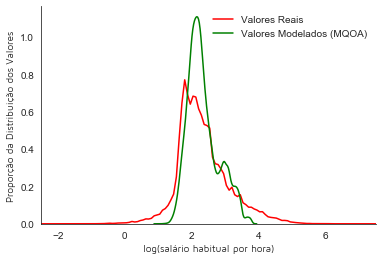

In [ ]:
## vendo a comparação das distribuições dos valores previstos x reais
# mesmo não sendo o foco do trabalho, dá pra ter uma ideia de quais valores de salários são mais faceis de serem preditos
sns.set_style(style="white")
fig, ax = plt.subplots(figsize = (6,4))

# plottanndo as curvas
sns.distplot(dfp['lsalh'], hist = False, color = 'r', label = 'Valores Reais', bins = 1)
sns.distplot(yhat, hist = False, color = 'g', label = 'Valores Modelados (MQOA)', bins = 1)

## deixando o gráfico bonitinho
sns.despine()
ax.legend(loc='upper right', frameon = False)

## labels dos eixos
ax.set_xlabel("log(salário habitual por hora)", fontname = "Maven Pro")
ax.set_xlim(-2.5,7.5)
# ax.set_xlim(0,6)
ax.set_ylabel("Proporção da Distribuição dos Valores", fontname = "Maven Pro")
plt.savefig("dist_lsalh.png", dpi = 300)

# modelo não preve bem valores pequenos ou extremos, mas faz um bom trabalho nos valores mais comuns (até lsalh = 3 ou salh ≈ R$ 20)

In [ ]:
dfp['lsalh'].describe()

count    120110.000000
mean          2.334676
std           0.763862
min          -2.484907
25%           1.832581
50%           2.207275
75%           2.730523
max           7.641724
Name: lsalh, dtype: float64

In [ ]:
## comparando todos os modelos
mods = [mod1,mod2,mod3,mod4,mod6,mod8,mod9,mod10,mod11]
mods_names = ["A","B","C","D","E","F","G","H","I"]
dict_compare = dict(zip(mods_names, mods))

mods1 = [mod1,mod2,mod3]
mods_names1 = ["A","B","C"]
dict_compare1 = dict(zip(mods_names1, mods1))

mods2 = [mod4,mod6,mod8]
mods_names2 = ["D","E","F"]
dict_compare2 = dict(zip(mods_names2, mods2))

mods3 = [mod9,mod10,mod11]
mods_names3 = ["G","H","I"]
dict_compare3 = dict(zip(mods_names3, mods3))

compare_obj = compare(dict_compare, precision='pvalues',stars = True)
print(compare_obj.summary)

                                                                Model Comparison                                                                
                                 A            B            C             D             E             F             G             H             I
------------------------------------------------------------------------------------------------------------------------------------------------
Dep. Variable                lsalh        lsalh        lsalh         lsalh         lsalh         lsalh         lsalh         lsalh         lsalh
Estimator                PooledOLS    PooledOLS    PooledOLS     PooledOLS     PooledOLS     PooledOLS     PooledOLS     PooledOLS     PooledOLS
No. Observations            120110       120110       120110        120110        120110        120110        120110        120110        120110
Cov. Est.                   Robust       Robust       Robust        Robust        Robust        Robust        Robust        Robust

In [ ]:
## printando a tabela de comparação separada em 2
compare_obj1 = compare(dict_compare1, precision='std_errors',stars = True)
compare_obj2 = compare(dict_compare2, precision='std_errors',stars = True)
compare_obj3 = compare(dict_compare3, precision='std_errors',stars = True)
print(compare_obj1.summary.as_latex())
print(compare_obj2.summary.as_latex())
print(compare_obj3.summary.as_latex())

\begin{center}
\begin{tabular}{lccc}
\toprule
                               &   \textbf{A}  &  \textbf{B}  &  \textbf{C}   \\
\midrule
\textbf{Dep. Variable}         &     lsalh     &    lsalh     &    lsalh      \\
\textbf{Estimator}             &   PooledOLS   &  PooledOLS   &  PooledOLS    \\
\textbf{No. Observations}      &     120110    &    120110    &    120110     \\
\textbf{Cov. Est.}             &     Robust    &    Robust    &    Robust     \\
\textbf{R-squared}             &     0.2546    &    0.2835    &    0.2836     \\
\textbf{R-Squared (Within)}    &    -0.0755    &   -0.0874    &   -0.0874     \\
\textbf{R-Squared (Between)}   &     0.2893    &    0.3256    &    0.3256     \\
\textbf{R-Squared (Overall)}   &     0.2546    &    0.2835    &    0.2836     \\
\textbf{F-statistic}           &   1.025e+04   &    9505.7    &    7923.1     \\
\textbf{P-value (F-stat)}      &     0.0000    &    0.0000    &    0.0000     \\
\textbf{=====================} & ============= & =====

## TESTES DE ESPECIFICIDADE

In [ ]:
## fazendo o teste RESET
# capturando os quadrado e cubos dos valores ajustados
dfp['y2'] = Resultado.fitted_values**2
dfp['y3'] = Resultado.fitted_values**3

## adicionando-os ao modelo
x = dfp[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural','rural_ppi','cont_prev','y2','y3']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')
clear_output()

## fazendo o teste F
Teste_F_Rapido_Robusto('y2=y3=0')
# 

O valor de LM é 2098.664867 e seu p-valor é 0.0.
Portanto, rejeita-se Ho à significância de 5.0%, ou seja, as variáveis são conjuntamente significantes.


In [ ]:
## reescrevendo o modelo (pro resultado ficar o mesmo)
x = dfp[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural','rural_ppi','cont_prev']]
y = dfp['lsalh']

Reg_Painel_MQO_Agrupado(x,y, cov='robust')

                          PooledOLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                        0.3721
Estimator:                  PooledOLS   R-squared (Between):              0.4198
No. Observations:              120110   R-squared (Within):              -0.0664
Date:                Thu, May 20 2021   R-squared (Overall):              0.3721
Time:                        09:57:29   Log-likelihood                -1.101e+05
Cov. Estimator:                Robust                                           
                                        F-statistic:                      2453.8
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1698   Distribution:               F(29,120080)
Min Obs:                       1.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             1891.5
                            

## Instrumentando

Instrumentos para educ: educ_conjugue e psem (nascidos no primeiro semestre entram na escola mais cedo)
educ_conjugue é bom porque pessoas de niveis de educacao semelhante tendem a se casar

atenção: pessoas casadas tendem a ter mais aptidão, outra possível fonte de exogeneidade

Problema: instrumentar educ:ppi e educ:fem (parcela de educ é endogena). as variaveis até idadesq são exógenas?

In [ ]:
from linearmodels.iv import compare

In [ ]:
## criando a variável de nascido ou não no primeiro semestre
dfp['psem'] = dfp['V20081'].apply(lambda i: 1 if i <= 6 else 0)

In [ ]:
## Grupo que possui conjugues
dfp1 = dfp.dropna(subset = ['educ_conjugue'], axis = 0)

# vendo os resultados de MQOA (sem casado pq todos são)
formula = "lsalh ~ 1 + educ + educ:ppi + educ:feminino + fund_inc + fund_inc:ppi + fund_comp + fund_comp:ppi + med_inc + med_inc:ppi + med_comp + med_comp:ppi + sup_inc + sup_inc:ppi + sup_comp + sup_comp:ppi + idade + idadesq + ppi + feminino + feminino:ppi + chefe_dom + nf05 + nf05:ppi + DF + DF:ppi + rural + rural:ppi + cont_prev"

ols = IV2SLS.from_formula(formula, dfp1).fit(cov_type="robust")
print(ols)

                            OLS Estimation Summary                            
Dep. Variable:                  lsalh   R-squared:                      0.3692
Estimator:                        OLS   Adj. R-squared:                 0.3689
No. Observations:               74430   F-statistic:                 3.395e+04
Date:                Thu, May 20 2021   P-value (F-stat)                0.0000
Time:                        09:57:32   Distribution:                 chi2(28)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
Intercept         0.8462     0.0438     19.338     0.0000      0.7604      0.9320
educ              0.0656     0.0042     

#### Teste de Endogeneidade

#### Instrumentação por MQ2E em um modelo mais simples

In [ ]:
## modelo de MQO sem as não-linearidades e as diferenças no retorno da educação
formula = "lsalh ~ 1 + idade + idadesq + ppi + feminino + feminino:ppi + chefe_dom + nf05 + nf05:ppi + DF + DF:ppi + rural + rural:ppi + cont_prev + educ"
mod = IV2SLS.from_formula(formula, dfp1)
res = mod.fit(cov_type="robust")
print(res)

                            OLS Estimation Summary                            
Dep. Variable:                  lsalh   R-squared:                      0.3188
Estimator:                        OLS   Adj. R-squared:                 0.3187
No. Observations:               74430   F-statistic:                 2.726e+04
Date:                Thu, May 20 2021   P-value (F-stat)                0.0000
Time:                        09:57:33   Distribution:                 chi2(14)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
Intercept        0.3206     0.0334     9.6000     0.0000      0.2551      0.3860
idade            0.0487     0.0016     30.54

In [ ]:
## instrumentando
formula = "lsalh ~ 1 + [educ ~ psem + educ_conjugue] + idade + idadesq + ppi + feminino + feminino:ppi + chefe_dom + nf05 + nf05:ppi + DF + DF:ppi + rural + rural:ppi + cont_prev"
mod = IV2SLS.from_formula(formula, dfp1)
iv_res1 = mod.fit(cov_type="robust")
print(iv_res1)

print(compare({'MQOA':res, 'MQ2E':iv_res1}, precision = 'std_errors', stars=True).summary)
print(compare({'MQOA':res, 'MQ2E':iv_res1}, precision = 'std_errors', stars=True).summary.as_latex())
# coeficiente de educ sobe para 0,1271 (era 0,0811)
# ppi cai para -4,27% (era -11%) -> educação parece explicar a diferença de raça
# feminino aumenta para -33% (era - 27%) e feminino ppi se torna significante e aumenta para -2%
# rural se torna insignificante, ou seja, não parece mais a haver diferenças entre ambientes urbanos ou rurais
# coeficiente de DF cai; com o aumento do retorno da educação,as diferenças regionais parecem diminuir

                          IV-2SLS Estimation Summary                          
Dep. Variable:                  lsalh   R-squared:                      0.2712
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2711
No. Observations:               74430   F-statistic:                 2.355e+04
Date:                Thu, May 20 2021   P-value (F-stat)                0.0000
Time:                        09:57:34   Distribution:                 chi2(14)
Cov. Estimator:                robust                                         
                                                                              
                              Parameter Estimates                               
              Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------
Intercept       -0.1553     0.0361    -4.3058     0.0000     -0.2259     -0.0846
idade            0.0469     0.0017     28.33

In [ ]:
## fazendo o teste de endogeneidade
iv_res1.wooldridge_regression
## a variável educ é com certeza endógena

Wooldridge's regression test of exogeneity
H0: Endogenous variables are exogenous
Statistic: 2390.0109
P-value: 0.0000
Distributed: chi2(1)
WaldTestStatistic, id: 0x7fcfbbb20810

In [ ]:
## fazendo o teste de restrições sobreidentificadoras
iv_res1.wooldridge_overid
# não rejeitamos Ho, ou seja, os instrumentos são realmente exógenos

Wooldridge's score test of overidentification
H0: Model is not overidentified.
Statistic: 0.4387
P-value: 0.5077
Distributed: chi2(1)
WaldTestStatistic, id: 0x7fcfbbb026d0

In [ ]:
## vendo os resultados de 1o estagio
formula = "educ ~ 1 + idade + idadesq + ppi + feminino + feminino:ppi + chefe_dom + nf05 + nf05:ppi + DF + DF:ppi + rural + rural:ppi + cont_prev + psem + educ_conjugue"
mod = IV2SLS.from_formula(formula, dfp1)
Resultado = mod.fit(cov_type="robust")
print(Resultado)

## educ_conjugue é bastante relevante, psem nem tanto (há um catching up ao longo da idade). O teste F mostra que a condição de posto é satisfeita
# educ_conjugue era esperado, já que pessoas de educações semelhantes tendem a casar entre si
# assim, os instrumentos são exógenos (não sobreidentificados) e relevantes!! YEY! Variáveis instrumentais são boas!!!
Teste_F_Rapido_Robusto('psem = educ_conjugue = 0')

                            OLS Estimation Summary                            
Dep. Variable:                   educ   R-squared:                      0.4895
Estimator:                        OLS   Adj. R-squared:                 0.4894
No. Observations:               74430   F-statistic:                 8.405e+04
Date:                Thu, May 20 2021   P-value (F-stat)                0.0000
Time:                        09:57:38   Distribution:                 chi2(15)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
Intercept         4.4005     0.1513     29.089     0.0000      4.1040      4.6971
idade            -0.0091     0.0073    -

#### Modelo "fajuto" para incorporar nas estimações de VI as não-linearidades e as diferenças de gênero e raça no retorno da educação

In [ ]:
## fazendo a instrumentação na mão sem as variaveis de grau educ
# 1o estagio de MQ2E
formula = "educ ~ 1 + idade + idadesq + ppi + feminino + feminino:ppi + chefe_dom + nf05 + nf05:ppi + DF + DF:ppi + rural + rural:ppi + cont_prev + psem + educ_conjugue"
mod = IV2SLS.from_formula(formula, dfp1)
iv_res = mod.fit(cov_type="robust")
print(iv_res)

                            OLS Estimation Summary                            
Dep. Variable:                   educ   R-squared:                      0.4895
Estimator:                        OLS   Adj. R-squared:                 0.4894
No. Observations:               74430   F-statistic:                 8.405e+04
Date:                Thu, May 20 2021   P-value (F-stat)                0.0000
Time:                        09:57:39   Distribution:                 chi2(15)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
Intercept         4.4005     0.1513     29.089     0.0000      4.1040      4.6971
idade            -0.0091     0.0073    -

In [ ]:
## pegando os valores ajustados
dfp1['educ'] = iv_res.fitted_values
# guardando os residuos
dfp1['v2'] = iv_res.resids
clear_output()

In [ ]:
# 2o estagio
formula = "lsalh ~ 1 + educ + educ:ppi + educ:feminino + fund_inc + fund_inc:ppi + fund_comp + fund_comp:ppi + med_inc + med_inc:ppi + med_comp + med_comp:ppi + sup_inc + sup_inc:ppi + sup_comp + sup_comp:ppi + idade + idadesq + ppi + feminino + feminino:ppi + chefe_dom + nf05 + nf05:ppi + DF + DF:ppi + rural + rural:ppi + cont_prev"
mod = IV2SLS.from_formula(formula, dfp1)
iv_res = mod.fit(cov_type="robust")
print(iv_res)

# efeito de anos de educ aumenta, educ_ppi fica igual e educ_feminino é bem significante e negativo, não mais sendo insignificante
# dummies de grau_educ e ppi invertem o sinal
# feminino continua bastante negativo e fem:ppi é insignificante, assim como o número de filhos
# diferença ppi em ambientes rurais perde um pouco da significância, mas ainda é bastante relevante economicamente
# df continua racista
# ppi é positivo quando se considera uma pessoa com 0 anos de educação, o que se inverte a medida que há mais escolaridade

                            OLS Estimation Summary                            
Dep. Variable:                  lsalh   R-squared:                      0.3847
Estimator:                        OLS   Adj. R-squared:                 0.3845
No. Observations:               74430   F-statistic:                 3.629e+04
Date:                Thu, May 20 2021   P-value (F-stat)                0.0000
Time:                        09:57:42   Distribution:                 chi2(28)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
Intercept         0.2956     0.0463     6.3768     0.0000      0.2047      0.3864
educ              0.0770     0.0024     

In [ ]:
## teste de endogeneidade
formula = "lsalh ~ 1 + educ + educ:ppi + educ:feminino + fund_inc + fund_inc:ppi + fund_comp + fund_comp:ppi + med_inc + med_inc:ppi + med_comp + med_comp:ppi + sup_inc + sup_inc:ppi + sup_comp + sup_comp:ppi + idade + idadesq + ppi + feminino + feminino:ppi + chefe_dom + nf05 + nf05:ppi + DF + DF:ppi + rural + rural:ppi + cont_prev + v2"
endog = IV2SLS.from_formula(formula, dfp1)
endog_res = endog.fit(cov_type="robust")
print(endog_res)

## educ é com certeza endógeno (v2 é bastante significante)
# o teste de restricoes sobreidentificadoras é o mesmo do modelo mais simples (1º estágio é o mesmo)

                            OLS Estimation Summary                            
Dep. Variable:                  lsalh   R-squared:                      0.3868
Estimator:                        OLS   Adj. R-squared:                 0.3865
No. Observations:               74430   F-statistic:                  3.66e+04
Date:                Thu, May 20 2021   P-value (F-stat)                0.0000
Time:                        09:57:44   Distribution:                 chi2(29)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
Intercept         0.3138     0.0463     6.7756     0.0000      0.2230      0.4046
educ              0.1083     0.0030     

In [ ]:
### comparando as estimativas em um ambiente urbano e fora do df frente ao grupo sem instrução e com 0 anos de ducação
params = dict(iv_res.params)
retorno_educ_ppi = 12*(params['educ'] + params['educ:ppi']) + params['med_comp'] + params['med_comp:ppi'] + params['ppi']
retorno_educ = 12*(params['educ']) + params['med_comp']

print("########## 'MQ2E' ##############\n")
print(f"Ensino Médio PPI: {round(100*retorno_educ_ppi,2)}%; Brancos: {round(100*retorno_educ,2)}%\nDiferença = {round(100*(retorno_educ-retorno_educ_ppi),2)}%.")

retorno_educ_ppi = 16*(params['educ'] + params['educ:ppi']) + params['sup_comp'] + params['sup_comp:ppi'] + params['ppi']
retorno_educ = 16*(params['educ']) + params['sup_comp']

print(f"Ensino Superior PPI: {round(100*retorno_educ_ppi,2)}%; Brancos: {round(100*retorno_educ,2)}%\nDiferença = {round(100*(retorno_educ-retorno_educ_ppi),2)}%.")

print("\n########## MQOA ##############\n")
params = dict(ols.params)

## para o ensino médio em um ambiente urbano e fora do df
retorno_educ_ppi = 12*(params['educ'] + params['educ:ppi']) + params['med_comp'] + params['med_comp:ppi'] + params['ppi']
retorno_educ = 12*(params['educ']) + params['med_comp']

print(f"Ensino Médio PPI: {round(100*retorno_educ_ppi,2)}%; Brancos: {round(100*retorno_educ,2)}%\nDiferença = {round(100*(retorno_educ-retorno_educ_ppi),2)}%.")
retorno_educ_ppi = 16*(params['educ'] + params['educ:ppi']) + params['sup_comp'] + params['sup_comp:ppi'] + params['ppi']
retorno_educ = 16*(params['educ']) + params['sup_comp']

print(f"Ensino Superior PPI: {round(100*retorno_educ_ppi,2)}%; Brancos: {round(100*retorno_educ,2)}%\nDiferença = {round(100*(retorno_educ-retorno_educ_ppi),2)}%.")

print("\nA diferença racial na educação é semelhante entre os modelos,\nmas o retorno da educação é bem maior no modelo MQ2E.")

########## 'MQ2E' ##############

Ensino Médio PPI: 115.47%; Brancos: 122.64%
Diferença = 7.18%.
Ensino Superior PPI: 207.28%; Brancos: 220.81%
Diferença = 13.53%.

########## MQOA ##############

Ensino Médio PPI: 46.09%; Brancos: 58.35%
Diferença = 12.26%.
Ensino Superior PPI: 122.34%; Brancos: 138.54%
Diferença = 16.19%.

A diferença racial na educação é semelhante entre os modelos,
mas o retorno da educação é bem maior no modelo MQ2E.


In [ ]:
## as médias da amostra parecem corroborar o resultado do modelo de MQ2E
df.groupby(['cor','grau_educ'])['renda_hab_prin'].mean().unstack()

grau_educ,fund_completo,fund_incompleto,medio_completo,medio_incompleto,sem_instrucao,superior_completo,superior_incompleto
cor,,,,,,,
,NaN,2979.000000,10000.000000,NaN,NaN,17166.666667,3000.000000
amarela,1480.236364,1461.674797,2362.660377,1516.416667,1550.000000,6343.716667,2543.821429
branca,1941.229784,1683.023314,2145.013596,1752.386879,1282.710383,5198.113975,2129.577320
indigena,1509.882353,1162.580153,1493.848214,1175.516129,1227.913043,5006.405797,2715.260870
parda,1519.763976,1437.634267,1757.536377,1419.854580,1211.498744,4221.754039,1830.167428
preta,1451.646444,1413.142388,1709.506525,1425.677492,1210.444444,3968.399207,1835.793930


In [ ]:
## comparando com o modelo de OLS
print(compare({'MQOA':ols, 'MQ2E':iv_res}, precision = 'std_errors', stars=True).summary)
print(compare({'MQOA':ols, 'MQ2E':iv_res}, precision = 'std_errors', stars=True).summary.as_latex())

               Model Comparison               
                            MQOA          MQ2E
----------------------------------------------
Dep. Variable              lsalh         lsalh
Estimator                    OLS           OLS
No. Observations           74430         74430
Cov. Est.                 robust        robust
R-squared                 0.3692        0.3847
Adj. R-squared            0.3689        0.3845
F-statistic            3.395e+04     3.629e+04
P-value (F-stat)          0.0000        0.0000
================== ============= =============
Intercept              0.8462***     0.2956***
                        (0.0438)      (0.0463)
educ                   0.0656***     0.0770***
                        (0.0042)      (0.0024)
educ:ppi              -0.0176***    -0.0135***
                        (0.0048)      (0.0026)
educ:feminino         -0.0043***    -0.0110***
                        (0.0013)      (0.0018)
fund_inc              -0.1103***     0.1293***
             

## MODELOS DE PAINEL

In [ ]:
from linearmodels.panel import compare

In [ ]:
## criando um df novo para tirar as pessoas que mudam de raça/genero ao longo do tempo
dfp2 = dfp

In [ ]:
## fazendo a média de todas as variáveis que sofrem alteração temporal
for column in dfp2[['feminino','ppi','educ']]:
    string = f"m{column}"
    dfp2[string] = dfp2.groupby('individuo')[column].transform('mean')

In [ ]:
## criando funcoes pra ver quantos individuos são assim
def fem_cte(s):
    if s['feminino'] == s['mfeminino']:
        return 1
    else:
        return 0

def ppi_cte(s):
    if s['ppi'] == s['mppi']:
        return 1
    else:
        return 0

dfp2['fem_cte'] = dfp2.apply(fem_cte, axis = 1)
dfp2['ppi_cte'] = dfp2.apply(ppi_cte, axis = 1)

In [ ]:
## feminino é bem pouquinha gente
dfp2['fem_cte'].value_counts()

1    120079
0        31
Name: fem_cte, dtype: int64

In [ ]:
## ppi é uma galeeera
dfp2['ppi_cte'].value_counts()

1    89013
0    31097
Name: ppi_cte, dtype: int64

In [ ]:
## vendo educacao constante
def educ_cte(s):
    if s['educ'] == s['meduc']:
        return 1
    else:
        return 0

dfp2['educ_cte'] = dfp2.apply(educ_cte, axis = 1)
dfp2['educ_cte'].value_counts()
# 55k de observacoes possuem educ diferente de suas medias temporais

1    64634
0    55476
Name: educ_cte, dtype: int64

In [ ]:
## droppanndo as observacoes com mudanca de feminino
dfp2 = dfp2.loc[dfp2['feminino'] == dfp2['mfeminino']]

In [ ]:
## modelo 1: com todas as dummies e efeitos fixos
x = dfp2[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural','rural_ppi','cont_prev']]
y = dfp2['lsalh']

Reg_Painel_Efeitos_Fixos(x,y, cov='robust')
ef_full = Resultado
# período de tempo muito curto não faz valer a pena colocar as dummies de tempo
# educ possui muita pouca variabilidade (SQTj cai, ep sobe)
# os coeficientes de dummies tem muita pouca variabilidade e, por isso, há perda de significância --> apesar de ef ser melhor, ela não permite identificar o coeficiente de ppi de maneira adequada
# DF é droppado, DF_PPI não; mudança na autodeclaração
# feminino: mudança de sexo ou erro no preenchimento
# variáveis de educação: poucos adultos estudam + não-instantaneidade dos efeitos da educação sobre o salário
# t-valores caem absurdamente: painel curto (5 trimestres no máximo, pra 33% da amostra) e a maioria das variáveis é constante no tempo

/Users/vinicius/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/linearmodels/panel/model.py:1726: AbsorbingEffectWarning:


Variables have been fully absorbed and have removed from the regression:

feminino, DF, rural


                          PanelOLS Estimation Summary                           
Dep. Variable:                  lsalh   R-squared:                        0.0051
Estimator:                   PanelOLS   R-squared (Between):              0.0678
No. Observations:              120079   R-squared (Within):               0.0051
Date:                Thu, May 20 2021   R-squared (Overall):              0.0672
Time:                        09:58:02   Log-likelihood                 -2.71e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      16.165
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1690   Distri

In [ ]:
## efeitos aleatórios (inconsistente se haver efeitos fixos)
x = dfp2[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural','rural_ppi','cont_prev']]
y = dfp2['lsalh']

Reg_Painel_Efeitos_Aleatórios(x,y, cov='robust')
ea_full = Resultado

                        RandomEffects Estimation Summary                        
Dep. Variable:                  lsalh   R-squared:                        0.2456
Estimator:              RandomEffects   R-squared (Between):              0.4007
No. Observations:              120079   R-squared (Within):              -0.0307
Date:                Thu, May 20 2021   R-squared (Overall):              0.3582
Time:                        09:58:05   Log-likelihood                -5.185e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1347.7
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1690   Distribution:               F(29,120049)
Min Obs:                       0.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             660.50
                            

In [ ]:
## comparandos os resultados
print(compare({'MQO':mqo_full,'EF':ef_full, 'EA':ea_full}, precision='std_errors'))
# EA sempre entre MQO
# quanto maior for a variancia do efeito nao observado, mais proximo de EF
# educ é um dos mais relevantes e sua estimação por EA é bem próxima da média de EF e EA
# ppi deixa de ser significante (e suas interacoes em geral) - pouca gente muda a autodeclaração (frente a amostra como um todo)
# feminino é bastante e bem próximo de MQOA
# fem_ppi se torna insignificante
# cont_prev é relevante em todos os modelos -> formalização e salários caminham lado a lado e tem uma resposta rápida entre si
# demissao de emprego formal -> bico informal em um trimestre?

                           Model Comparison                           
                                    MQO           EF                EA
----------------------------------------------------------------------
Dep. Variable                     lsalh        lsalh             lsalh
Estimator                     PooledOLS     PanelOLS     RandomEffects
No. Observations                 120110       120079            120079
Cov. Est.                        Robust       Robust            Robust
R-squared                        0.3721       0.0051            0.2456
R-Squared (Within)              -0.0664       0.0051           -0.0307
R-Squared (Between)              0.4198       0.0678            0.4007
R-Squared (Overall)              0.3721       0.0672            0.3582
F-statistic                      2453.8       16.165            1347.7
P-value (F-stat)                 0.0000       0.0000            0.0000
=====================     =============   ==========   ===============
const 

In [ ]:
## fazendo um teste de hausman com o modelo cheio
x = dfp2[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF_ppi','rural_ppi','cont_prev']]
y = dfp2['lsalh']

hausman_EF_EA(x,y)
# prefere-se (e muito) efeitos fixos: educação está muito correlacionada com efeitos não-observados

O valor de H é 4891.408107 com 26 graus de liberdade na distribuição chi2. O p-valor do teste é 0.0 e, portanto, se rejeita H0 e prefere-se o modelo de efeitos fixos.


In [ ]:
## modelo 2: sem as dummies de educação
x = dfp[['educ','educ_ppi','educ_fem','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural','rural_ppi','cont_prev']]
y = dfp['lsalh']
Reg_Painel_MQO_Agrupado(x,y, cov='robust')
mqo_slim = Resultado
clear_output()

x = dfp2[['educ','educ_ppi','educ_fem','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural','rural_ppi','cont_prev']]
y = dfp2['lsalh']
Reg_Painel_Efeitos_Fixos(x,y, cov='robust')
ef_slim = Resultado

                          PanelOLS Estimation Summary                           
Dep. Variable:                  lsalh   R-squared:                        0.0043
Estimator:                   PanelOLS   R-squared (Between):              0.0326
No. Observations:              120079   R-squared (Within):               0.0043
Date:                Thu, May 20 2021   R-squared (Overall):              0.0334
Time:                        09:58:14   Log-likelihood                -2.715e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      25.150
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1690   Distribution:                F(14,82181)
Min Obs:                       0.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             18.227
                            

In [ ]:
## efeitos aleatórios
x = dfp2[['educ','educ_ppi','educ_fem','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural','rural_ppi','cont_prev']]
y = dfp2['lsalh']
Reg_Painel_Efeitos_Aleatórios(x,y, cov='robust')
ea_slim = Resultado

                        RandomEffects Estimation Summary                        
Dep. Variable:                  lsalh   R-squared:                        0.2170
Estimator:              RandomEffects   R-squared (Between):              0.3474
No. Observations:              120079   R-squared (Within):              -0.0325
Date:                Thu, May 20 2021   R-squared (Overall):              0.3058
Time:                        09:58:16   Log-likelihood                -5.223e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1956.7
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1690   Distribution:               F(17,120061)
Min Obs:                       0.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             836.28
                            

In [ ]:
print(compare({'MQO':mqo_slim,'EF':ef_slim,'EA':ea_slim,'MQO_Cheio':mqo_full,'EF_Cheio':ef_full,'EA_Cheio':ea_full}, precision='pvalues').summary)
# diferença de educ é maior nos efeitos aleatórios (quase o dobro no modelo mais de boa)
# estatística F de efeitos cai bastante, o que indica que não conseguimos explicar direito as variações em lsalh (vide r2 baixissimo)

                                                      Model Comparison                                                     
                                    MQO              EF                EA       MQO_Cheio        EF_Cheio          EA_Cheio
---------------------------------------------------------------------------------------------------------------------------
Dep. Variable                     lsalh           lsalh             lsalh           lsalh           lsalh             lsalh
Estimator                     PooledOLS        PanelOLS     RandomEffects       PooledOLS        PanelOLS     RandomEffects
No. Observations                 120110          120079            120079          120110          120079            120079
Cov. Est.                        Robust          Robust            Robust          Robust          Robust            Robust
R-squared                        0.3280          0.0043            0.2170          0.3721          0.0051            0.2456
R-Square

In [ ]:
## fazendo um teste de hausman com o modelo menor
x = dfp2[['educ','educ_ppi','educ_fem','idade','idadesq','ppi','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF_ppi','rural_ppi','cont_prev']]
y = dfp2['lsalh']

hausman_EF_EA(x,y)

O valor de H é 5682.595447 com 14 graus de liberdade na distribuição chi2. O p-valor do teste é 0.0 e, portanto, se rejeita H0 e prefere-se o modelo de efeitos fixos.


** Efeitos Aleatórios Correlacionados **

In [ ]:
## fazendo a média de todas as variáveis que sofrem alteração temporal
for column in dfp2[['educ','educ_ppi','educ_fem','idade','idadesq','ppi','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF_ppi','rural_ppi','cont_prev',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi']]:
    string = f"m{column}"
    dfp2[string] = dfp2.groupby('individuo')[column].transform('mean')
clear_output()

In [ ]:
## fazendo EAC
x = dfp2[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi', "med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural','rural_ppi','cont_prev','meduc','meduc_ppi','meduc_fem','midade','midadesq','mppi','mfem_ppi','mchefe_dom','mcasado','mnf05','mnf05_ppi','mDF_ppi','mrural_ppi','mcont_prev',"mfund_inc",'mfund_inc_ppi',"mfund_comp",'mfund_comp_ppi',"mmed_inc", 'mmed_inc_ppi',"mmed_comp", 'mmed_comp_ppi','msup_inc','msup_inc_ppi','msup_comp', 'msup_comp_ppi']]
y = dfp2['lsalh']

Reg_Painel_Efeitos_Aleatórios(x,y, cov='robust')
eac_full = Resultado
# educ com pouca variação e efeitos mais a longo prazo

                        RandomEffects Estimation Summary                        
Dep. Variable:                  lsalh   R-squared:                        0.2722
Estimator:              RandomEffects   R-squared (Between):              0.4212
No. Observations:              120079   R-squared (Within):               0.0051
Date:                Thu, May 20 2021   R-squared (Overall):              0.3843
Time:                        09:58:25   Log-likelihood                -4.969e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      816.01
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1690   Distribution:               F(55,120023)
Min Obs:                       0.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             440.60
                            

In [ ]:
## fazendo a mesma coisa pro modelo mais de boa
x = dfp2[['educ','educ_ppi','educ_fem','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural','rural_ppi','cont_prev','meduc','meduc_ppi','meduc_fem','midade','midadesq','mppi','mfem_ppi','mchefe_dom','mcasado','mnf05','mnf05_ppi','mDF_ppi','mrural_ppi','mcont_prev']]
y = dfp2['lsalh']

Reg_Painel_Efeitos_Aleatórios(x,y, cov='robust')
equation()
eac_slim = Resultado

                        RandomEffects Estimation Summary                        
Dep. Variable:                  lsalh   R-squared:                        0.2481
Estimator:              RandomEffects   R-squared (Between):              0.3773
No. Observations:              120079   R-squared (Within):               0.0043
Date:                Thu, May 20 2021   R-squared (Overall):              0.3431
Time:                        09:58:28   Log-likelihood                -4.979e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      1278.0
Entities:                       37892   P-value                           0.0000
Avg Obs:                       3.1690   Distribution:               F(31,120047)
Min Obs:                       0.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             626.68
                            

In [ ]:
## comparando todos os modelos
from linearmodels.panel import compare
print(compare({'MQO':mqo_slim,'EF':ef_slim,'EAC':eac_slim,'EA':ea_slim,'MQO_Cheio':mqo_full,'EF_Cheio':ef_full,'EAC_Cheio':eac_full,'EA_Cheio':ea_full}, precision='pvalues').summary)

                                                                        Model Comparison                                                                       
                                    MQO              EF               EAC                EA       MQO_Cheio        EF_Cheio         EAC_Cheio          EA_Cheio
---------------------------------------------------------------------------------------------------------------------------------------------------------------
Dep. Variable                     lsalh           lsalh             lsalh             lsalh           lsalh           lsalh             lsalh             lsalh
Estimator                     PooledOLS        PanelOLS     RandomEffects     RandomEffects       PooledOLS        PanelOLS     RandomEffects     RandomEffects
No. Observations                 120110          120079            120079            120079          120110          120079            120079            120079
Cov. Est.                        Robust 

In [ ]:
## vendo só os modelos completos
print(compare({'MQOA':mqo_full,'EF':ef_full,'EAC':eac_full,'EA':ea_full}, precision='std_errors', stars = True).summary)
print(compare({'MQOA':mqo_full,'EF':ef_full,'EAC':eac_full,'EA':ea_full}, precision='std_errors', stars = True).summary.as_latex())

                                     Model Comparison                                     
                                   MQOA             EF               EAC                EA
------------------------------------------------------------------------------------------
Dep. Variable                     lsalh          lsalh             lsalh             lsalh
Estimator                     PooledOLS       PanelOLS     RandomEffects     RandomEffects
No. Observations                 120110         120079            120079            120079
Cov. Est.                        Robust         Robust            Robust            Robust
R-squared                        0.3721         0.0051            0.2722            0.2456
R-Squared (Within)              -0.0664         0.0051            0.0051           -0.0307
R-Squared (Between)              0.4198         0.0678            0.4212            0.4007
R-Squared (Overall)              0.3721         0.0672            0.3843            0.3582

In [ ]:
from linearmodels.iv import compare
print(compare({'MQ2E':iv_res1,'MQ2E Completo':iv_res}, precision = 'std_errors', stars = True).summary)
print(compare({'MQ2E':iv_res1,'MQ2E Completo':iv_res}, precision = 'std_errors', stars = True).summary.as_latex())
## educ é 0,647 no modelo de MQO e cai bastante nos modelos de painel - baixa variabilidade da amostra e pouca precisao na estimação; nos modelos de MQ2E, o coeficiente de educ aumenta (para 0,1271 no modelo mais imples e para 0,07 no modelo fajuto)
# educ_ppi sempre negativo, mas mais próximo de 0 nas de painel
# educ_fem nao muda;
# idade quase nao muda;
# ppi: em EF e EAC fica nulo estatisticamente e economicamente; negativo em MQOA e EA; em MQ2E, é -0,04 (menos forte que o de MQO); contudo, no MQ2E fajuto, ppi é positivo, mas o retorno pra brancos fica maior conforme aumenta a educação (ver estimativas antes dos modelos de painel)
# feminino fica entre -0.24 e -0.33; estimação bastante precisa
# feminino_ppi só é est significantee em MQOA e MQ2E, com sinais opostos
# df sempre positivo df_ppi perde significancia nos modelos de painel, mas é est significante em MQOA e MQ2E (e bem negativo - df racista)
# rural sempre negativo e rural_ppi sempre positivo, menos no modelo de MQ2E fajuto

                  Model Comparison                  
                                MQ2E   MQ2E Completo
----------------------------------------------------
Dep. Variable                  lsalh           lsalh
Estimator                    IV-2SLS             OLS
No. Observations               74430           74430
Cov. Est.                     robust          robust
R-squared                     0.2712          0.3847
Adj. R-squared                0.2711          0.3845
F-statistic                2.355e+04       3.629e+04
P-value (F-stat)              0.0000          0.0000
==================      ============   =============
Intercept                 -0.1553***       0.2956***
                            (0.0361)        (0.0463)
idade                      0.0469***       0.0361***
                            (0.0017)        (0.0016)
idadesq                   -0.0004***      -0.0003***
                          (2.01e-05)     (1.887e-05)
ppi                       -0.0427***       0.1

In [ ]:
## droppando ppis
dfp3 = dfp2.loc[dfp2['ppi'] == dfp2['mppi']]

In [ ]:
dfp3['educ_cte'].value_counts()

1    50467
0    38526
Name: educ_cte, dtype: int64

In [ ]:
## comparando os modelos
from linearmodels.panel import compare
x = dfp3[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural','rural_ppi','cont_prev']]
y = dfp3['lsalh']

Reg_Painel_Efeitos_Fixos(x,y, cov='robust')
ef_full = Resultado

Reg_Painel_Efeitos_Aleatórios(x,y, cov='robust')
ea_full = Resultado

x = dfp3[['educ','educ_ppi','educ_fem','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural','rural_ppi','cont_prev']]
y = dfp3['lsalh']

Reg_Painel_Efeitos_Fixos(x,y, cov='robust')
ef_slim = Resultado

Reg_Painel_Efeitos_Aleatórios(x,y, cov='robust')
ea_slim = Resultado

x = dfp3[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi', "med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural','rural_ppi','cont_prev','meduc','meduc_ppi','meduc_fem','midade','midadesq','mchefe_dom','mcasado','mnf05','mnf05_ppi','mcont_prev',"mfund_inc",'mfund_inc_ppi',"mfund_comp",'mfund_comp_ppi',"mmed_inc", 'mmed_inc_ppi',"mmed_comp", 'mmed_comp_ppi','msup_inc','msup_inc_ppi','msup_comp', 'msup_comp_ppi']]
y = dfp3['lsalh']

Reg_Painel_Efeitos_Aleatórios(x,y, cov='robust')
eac_full = Resultado

x = dfp3[['educ','educ_ppi','educ_fem','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural','rural_ppi','cont_prev','meduc','meduc_ppi','meduc_fem','midade','midadesq','mchefe_dom','mcasado','mnf05','mnf05_ppi','mcont_prev']]
y = dfp3['lsalh']

Reg_Painel_Efeitos_Aleatórios(x,y, cov='robust')
eac_slim = Resultado

clear_output()
print(compare({'MQO':mqo_slim,'EF':ef_slim,'EAC':eac_slim,'EA':ea_slim,'MQO_Cheio':mqo_full,'EF_Cheio':ef_full,'EAC_Cheio':eac_full,'EA_Cheio':ea_full}, precision='pvalues').summary)

                                                                        Model Comparison                                                                       
                                    MQO              EF               EAC                EA       MQO_Cheio        EF_Cheio         EAC_Cheio          EA_Cheio
---------------------------------------------------------------------------------------------------------------------------------------------------------------
Dep. Variable                     lsalh           lsalh             lsalh             lsalh           lsalh           lsalh             lsalh             lsalh
Estimator                     PooledOLS        PanelOLS     RandomEffects     RandomEffects       PooledOLS        PanelOLS     RandomEffects     RandomEffects
No. Observations                 120110           88993             88993             88993          120110           88993             88993             88993
Cov. Est.                        Robust 

In [ ]:
## droppando educs não constantes
dfp3 = dfp2.loc[dfp2['educ'] == dfp2['meduc']]

for column in dfp3[['educ','educ_ppi','educ_fem','idade','idadesq','ppi','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF_ppi','rural_ppi','cont_prev',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi']]:
    string = f"m{column}"
    dfp3[string] = dfp3.groupby('individuo')[column].transform('mean')

## comparando os modelos
x = dfp3[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi',"med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural','rural_ppi','cont_prev']]
y = dfp3['lsalh']

Reg_Painel_Efeitos_Fixos(x,y, cov='robust')
ef_full = Resultado

Reg_Painel_Efeitos_Aleatórios(x,y, cov='robust')
ea_full = Resultado

x = dfp3[['educ','educ_ppi','educ_fem',"fund_inc",'fund_inc_ppi',"fund_comp",'fund_comp_ppi', "med_inc", 'med_inc_ppi',"med_comp", 'med_comp_ppi','sup_inc','sup_inc_ppi','sup_comp', 'sup_comp_ppi','idade','idadesq','ppi','feminino','fem_ppi','chefe_dom','casado','nf05','nf05_ppi','DF','DF_ppi','rural','rural_ppi','cont_prev','meduc_ppi','midade','midadesq','mchefe_dom','mcasado','mnf05','mnf05_ppi','mppi','mfem_ppi','mcont_prev','mfund_inc_ppi','mfund_comp_ppi', 'mmed_inc_ppi', 'mmed_comp_ppi','msup_inc_ppi', 'msup_comp_ppi','mmed_inc','msup_inc','mDF_ppi','mrural_ppi']]
y = dfp3['lsalh']

Reg_Painel_Efeitos_Aleatórios(x,y, cov='robust')
eac_full = Resultado
clear_output()

print(compare({'MQO_Cheio':mqo_full,'EF_Cheio':ef_full,'EAC_Cheio':eac_full,'EA_Cheio':ea_full}, precision='pvalues').summary)

                                      Model Comparison                                     
                              MQO_Cheio        EF_Cheio         EAC_Cheio          EA_Cheio
-------------------------------------------------------------------------------------------
Dep. Variable                     lsalh           lsalh             lsalh             lsalh
Estimator                     PooledOLS        PanelOLS     RandomEffects     RandomEffects
No. Observations                 120110           64612             64612             64612
Cov. Est.                        Robust          Robust            Robust            Robust
R-squared                        0.3721          0.0036            0.3191            0.3117
R-Squared (Within)              -0.0664          0.0036            0.0036           -0.0049
R-Squared (Between)              0.4198         -0.0137            0.4474            0.4397
R-Squared (Overall)              0.3721          0.0205            0.4471       

## Modelos de MV

Usamos todas as observações, ou seja, dfpft

### Probit e Logit para determinar emprego

In [ ]:
from funcoes_econometria_v2 import *
clear_output()

In [ ]:
## substituindo rendas nulas
dfpft['renda_hab_prin'] = dfpft['renda_hab_prin'].replace(np.NaN, 0)
dfpft['renda_hab_hora'] = dfpft['renda_hab_hora'].replace(np.NaN, 0)
dfpft['lsalh'] = np.log(dfpft['renda_hab_hora'])
dfpft['lsalh'] = dfpft['lsalh'].replace([np.NaN, -np.inf], [0,0])
dfpft['cont_prev'] = dfpft['cont_prev'].replace(np.NaN, 0)

/Users/vinicius/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning:

divide by zero encountered in log



In [ ]:
print(dfpft[['lsalh']].describe())

               lsalh
count  178200.000000
mean        1.573613
std         1.261310
min        -2.484907
25%         0.000000
50%         1.832581
75%         2.430418
max         7.641724


In [ ]:
## criando uma variavel que capta a renda total do resto do domicilio
dfpft['renda_res_dom'] = dfpft.groupby(['iddom','data'])['renda_hab_prin'].transform('sum') - dfpft['renda_hab_prin']
dfpft['renda_res_dom1000'] = dfpft['renda_res_dom']/1000

In [ ]:
## variavel de desempregado ou fora da força de trabalho (desocupado ou fora_ft)
def emp(s):
    if (s['fora_ft'] == 1) or (s['desocupado'] == 1):
        return 0
    else:
        return 1

dfpft['emp'] = dfpft.apply(emp, axis = 1)

In [ ]:
dfpft['emp'].value_counts()

1    121983
0     56217
Name: emp, dtype: int64

In [ ]:
dfpft['emp'].describe()

count    178200.000000
mean          0.684529
std           0.464705
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: emp, dtype: float64

In [ ]:
## configurando o estilo dos plots
sns.set_style(style="white")
from matplotlib.colors import ListedColormap

In [ ]:
##  contagem de indivíduos por posicao de ocupacao
## criando o dataframe
g = dfpft.groupby(['cor', 'emp']).size().reset_index().pivot(columns='cor', index='emp', values=0)

# modificando as colunas para permitir a soma de cada categoria
g.columns = g.columns.astype(str)
g['total'] = g.sum(axis=1)

# criando um g com valores percentuais
g1 = g[['amarela','branca','indigena','parda','preta']].div(g.total, axis = 0)

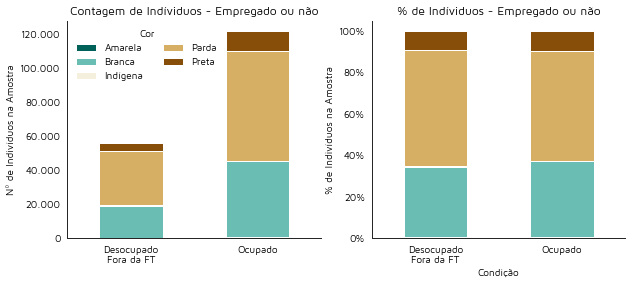

cor,,amarela,branca,indigena,parda,preta,total
emp,,,,,,,
0,2,351,19025,292,31569,4978,56217
1,8,825,44475,440,64850,11385,121983


In [ ]:
# objeto gráfico
fig, ax = plt.subplots(ncols = 2, figsize = (10,4))

labels_legenda = ['Amarela','Branca','Indígena', 'Parda','Preta']

## criando os objetos gráficos
ax11 = g[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[0])
ax21 = g1[['amarela','branca','indigena','parda','preta']].plot(kind='bar',stacked=True, colormap=ListedColormap(sns.color_palette("BrBG_r", 10)), ax = ax[1])

## alternado a legenda
ax11.legend(title = 'Cor', labels = labels_legenda, loc='upper left',ncol = 2, frameon = False)
plt.setp(ax11.get_legend().get_texts(), color = 'k', fontname = 'Maven Pro') # for legend text
plt.setp(ax11.get_legend().get_title(), color = 'k', fontname = 'Maven Pro') # for title text
ax21.legend([],[], frameon=False)

## alterando as categorias do eixo x

labels = ['Desocupado\nFora da FT', 'Ocupado']
for graph in [ax11,ax21]:
    graph.set_xticks([0,1])
    graph.set_xticklabels(labels = labels, rotation = 0, color = 'k', fontname = 'Maven Pro')
## alterando a formatação do eixo y
# contagem absoluta
for graph in [ax11]:
    numeros_formatados = ['{:,.0f}'.format(y).replace(',', '.') for y in graph.get_yticks()]
    graph.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

# percentual
for graph in [ax21]:
    numeros_formatados = ['{:,.0f}'.format(100*y).replace(',', '.') + "%" for y in graph.get_yticks()]
    graph.set_yticklabels(numeros_formatados, color = 'k', fontname = 'Maven Pro')

## alterando os títulos
ax11.set_title("Contagem de Indíviduos - Empregado ou não", color = 'k',fontname = 'Maven Pro')
ax11.set_xlabel("", color = 'k',fontname = 'Maven Pro')
ax11.set_ylabel("Nº de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

ax21.set_title("% de Indíviduos - Empregado ou não", color = 'k',fontname = 'Maven Pro')
ax21.set_xlabel("Condição", color = 'k',fontname = 'Maven Pro')
ax21.set_ylabel("% de Indivíduos na Amostra", color = 'k',fontname = 'Maven Pro')

## deixando apenas as linhas dos eixos e arrumando a largura das linhas
sns.despine()
for graph in [ax11, ax21]:
    for axis in ['top','bottom','left','right']:
        graph.spines[axis].set_linewidth(1)

## mostrando o plot
plt.savefig("setor_emprego_cor.png", dpi = 300)
plt.show()
display(g)
# muito mais ocupados na amostra, sendo que há um equilibriio relativo entre as cores
# 68,5% da população está ocupada

In [ ]:
## vendo por genero
g = dfpft.groupby(['feminino', 'emp']).size().reset_index().pivot(columns='feminino', index='emp', values=0)

# modificando as colunas para permitir a soma de cada categoria
g.columns = g.columns.astype(str)
g['total'] = g.sum(axis=1)

display(g)
## 70% das mulheres não estam empregadas, o que justifica o alto coeficiente do tobit (-0.96)

feminino,0,1,total
emp,,,
0,16623,39594,56217
1,69696,52287,121983


In [ ]:
## variavel de filhos com menores de 5 anos e maior que isso
dfpft.rename(columns={'num_filhos_05':'nf05','num_filhos_06_10':'nf06_10','num_filhos_11_18':'nf11_18','num_filhos_18m':'nf18m','num_filhos':'nf'}, inplace = True)

dfpft['nf06m'] = dfpft['nf06_10'] + dfpft['nf11_18'] + dfpft['nf18m']

In [ ]:
## renomeando a coluna de ppi
dfpft.rename(columns = {'preta_parda_ind':'ppi'}, inplace=True)

In [ ]:
dfpft.rename(columns = {"sem_instrucao":"si","fund_incompleto":"fund_inc","fund_completo":"fund_comp","medio_incompleto":"med_inc","medio_completo":"med_comp",'superior_incompleto':"sup_inc",'superior_completo':"sup_comp"}, inplace=True)

In [ ]:
## vendo por probit
formula = 'emp ~ 1 + renda_res_dom1000 + educ + educ:feminino + educ:ppi + idade + idadesq + nf05 + nf06m + feminino + ppi + feminino:ppi + casado + chefe_dom + DF + DF:ppi + rural + rural:ppi'
formula2 = 'emp ~ 1 + renda_res_dom1000 + educ +educ:feminino + educ:ppi + fund_inc + fund_inc:ppi + fund_comp + fund_comp:ppi + med_inc + med_inc:ppi + med_comp + med_comp:ppi + sup_inc + sup_inc:ppi + sup_comp + sup_comp:ppi + idade + idadesq + nf05 + nf06m + feminino + ppi + feminino:ppi + casado + chefe_dom + DF + DF:ppi + rural + rural:ppi'

mod_probit = probit_logit(formula = formula, data = dfpft)
## sem as interacoes de educ:fem e educ:ppi, nf era positivo; agora, se torna negativo
# rural é bem insignificante

                          Probit Regression Results                           
Dep. Variable:                    emp   No. Observations:               178200
Model:                         Probit   Df Residuals:                   178182
Method:                           MLE   Df Model:                           17
Date:                Thu, 20 May 2021   Pseudo R-squ.:                  0.1417
Time:                        09:59:07   Log-Likelihood:                -95347.
converged:                       True   LL-Null:                   -1.1109e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.1131      0.038    -55.501      0.000      -2.188      -2.039
renda_res_dom1000    -0.0079      0.001     -8.732      0.000      -0.010      -0.006
educ                  0.

In [ ]:
## vendo por logit
mod_logit = probit_logit(formula = formula, data = dfpft, model = logit)

                           Logit Regression Results                           
Dep. Variable:                    emp   No. Observations:               178200
Model:                          Logit   Df Residuals:                   178182
Method:                           MLE   Df Model:                           17
Date:                Thu, 20 May 2021   Pseudo R-squ.:                  0.1412
Time:                        09:59:11   Log-Likelihood:                -95407.
converged:                       True   LL-Null:                   -1.1109e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -3.5758      0.064    -55.650      0.000      -3.702      -3.450
renda_res_dom1000    -0.0134      0.002     -8.772      0.000      -0.016      -0.010
educ                  0.

In [ ]:
## vendo por MPL
mod_mqo = OLS_reg(formula = formula, data = dfpft)

                            OLS Regression Results                            
Dep. Variable:                    emp   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     2134.
Date:                Thu, 20 May 2021   Prob (F-statistic):               0.00
Time:                        09:59:12   Log-Likelihood:                -99781.
No. Observations:              178200   AIC:                         1.996e+05
Df Residuals:                  178182   BIC:                         1.998e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1610      0.01

In [ ]:
mod_probit2 = probit_logit(formula = formula2, data = dfpft)
mod_logit2 = probit_logit(formula = formula2, data = dfpft, model = logit)
mod_mqo2 = OLS_reg(formula = formula2, data = dfpft)
clear_output()
print(mod_probit2.summary())

                          Probit Regression Results                           
Dep. Variable:                    emp   No. Observations:               178200
Model:                         Probit   Df Residuals:                   178170
Method:                           MLE   Df Model:                           29
Date:                Thu, 20 May 2021   Pseudo R-squ.:                  0.1441
Time:                        09:59:36   Log-Likelihood:                -95086.
converged:                       True   LL-Null:                   -1.1109e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -2.1937      0.051    -43.099      0.000      -2.293      -2.094
renda_res_dom1000    -0.0085      0.001     -9.279      0.000      -0.010      -0.007
educ                  0.

In [ ]:
## efeitos marginais do probit
print(mod_probit2.get_margeff().summary())
## no probit e no MQO, educ:ppi é insignificante, assim como a maioria das dummies de educação (com exceção do fundamental): assim, a educação afeta a probabilidade de participação na força de trabalho de forma igual entre as raças a partir do ensino fundamental completo. os sinais e magnitudes das dummies são bastanteee parecidos
#nf bem parecido e só nf05 é relevante economicamente e estatisticamente
# renda_res_dom é igual entre os modelos, mas bem pequeno uma vez que se controla para outros fatores
# educ é um pouco maior no probit e educ_feminino é positvo nos dois
# rural é insignificante est no probit, mas marginalmente significante no mqo; rural_ppi é insignificante em ambos
# pessoas do df teem maior desemprego! (geralmente tem maior educacao e renda)

       Probit Marginal Effects       
Dep. Variable:                    emp
Method:                          dydx
At:                           overall
                       dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
renda_res_dom1000    -0.0026      0.000     -9.285      0.000      -0.003      -0.002
educ                  0.0050      0.002      2.881      0.004       0.002       0.008
educ:feminino         0.0132      0.000     27.470      0.000       0.012       0.014
educ:ppi             -0.0006      0.002     -0.273      0.785      -0.005       0.003
fund_inc              0.1160      0.015      7.856      0.000       0.087       0.145
fund_inc:ppi         -0.0492      0.017     -2.868      0.004      -0.083      -0.016
fund_comp             0.1184      0.020      5.925      0.000       0.079       0.158
fund_comp:ppi        -0.0506      0.023     -2.155      0.031      -0.097 

In [ ]:
## vendo os efeitos marginais no MPL
print(mod_mqo2.summary())

                            OLS Regression Results                            
Dep. Variable:                    emp   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     1270.
Date:                Thu, 20 May 2021   Prob (F-statistic):               0.00
Time:                        09:59:47   Log-Likelihood:                -99552.
No. Observations:              178200   AIC:                         1.992e+05
Df Residuals:                  178170   BIC:                         1.995e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.1962      0.01

In [ ]:
## vendo a % corretamente predita
dfpft['emp_probit'] = mod_probit2.predict()
dfpft['emp_probit'] = dfpft['emp_probit'].apply(lambda i: 1 if i > 0.5 else 0)

In [ ]:
def corr_predita(s):
    if s['emp'] == s['emp_probit']:
        return 1
    else:
        return 0

dfpft['corr_predita'] = dfpft.apply(corr_predita, axis = 1)

In [ ]:
print(f"A porcentagem corretamente predita é {np.around(len(dfpft['corr_predita'].loc[dfpft['corr_predita'] == 1])/len(dfpft['corr_predita'])*100,2)}%.")

A porcentagem corretamente predita é 72.99%.


In [ ]:
dfpft['corr_predita'].value_counts()

1    130063
0     48137
Name: corr_predita, dtype: int64

In [ ]:
mod_probit2 = probit_logit(formula = "emp ~ 1 + educ + educ:ppi + educ:feminino + fund_inc + fund_inc:ppi + fund_comp + fund_comp:ppi + med_inc + med_inc:ppi + med_comp + med_comp:ppi + sup_inc + sup_inc:ppi + sup_comp + sup_comp:ppi + idade + idadesq + ppi + feminino + feminino:ppi + chefe_dom + casado + nf05 + nf05:ppi + DF + DF:ppi + rural + rural:ppi + renda_res_dom", data = dfpft)

                          Probit Regression Results                           
Dep. Variable:                    emp   No. Observations:               178200
Model:                         Probit   Df Residuals:                   178170
Method:                           MLE   Df Model:                           29
Date:                Thu, 20 May 2021   Pseudo R-squ.:                  0.1441
Time:                        10:00:07   Log-Likelihood:                -95078.
converged:                       True   LL-Null:                   -1.1109e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.1795      0.050    -43.493      0.000      -2.278      -2.081
educ              0.0161      0.006      2.769      0.006       0.005       0.027
educ:ppi         -0.0007      0.007     

### Poisson para nº de filhos

In [ ]:
formula = "nf ~ educ + educ:ppi + educ:feminino + idade + idadesq + ppi + feminino + feminino:ppi + DF + DF:ppi + rural + rural:ppi + renda_hab_hora"
mod = poisson_reg(formula = formula, data = dfp)
yhat = mod.predict()
## segue uma distribuição poisson direitinho (sigma é 1.08!
# baixo Rˆ2: o modelo só consegue prever bem casos de 1 filho
# nos efeitos marginais, 1 ano de educação reduz em 1,83% o número de filhos
# um real a mais de renda por hora aumenta em 0,1% o número de filhos (algo contraintuitivo);

                          Poisson Regression Results                          
Dep. Variable:                     nf   No. Observations:               120110
Model:                        Poisson   Df Residuals:                   120096
Method:                           MLE   Df Model:                           13
Date:                Thu, 20 May 2021   Pseudo R-squ.:                 0.07060
Time:                        10:00:09   Log-Likelihood:            -1.4585e+05
converged:                       True   LL-Null:                   -1.5692e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -5.8012      0.050   -115.093      0.000      -5.900      -5.702
educ              -0.0183      0.001    -12.418      0.000      -0.021      -0.015
educ:ppi          -0.0027      0.002

In [ ]:
dfp['yhat'] = yhat

In [ ]:
dfp[['nf','yhat']].describe()

,nf,yhat
count,120110.000000,120110.000000
mean,0.889859,0.889859
std,1.062030,0.385097
min,0.000000,0.147264
25%,0.000000,0.563068
50%,1.000000,0.949490
75%,2.000000,1.201197
max,9.000000,9.137108


In [ ]:
dfp['nf'].value_counts()

0    58609
1    28579
2    23380
3     7379
4     1639
5      378
6       91
7       30
8       22
9        3
Name: nf, dtype: int64

(0, 9)

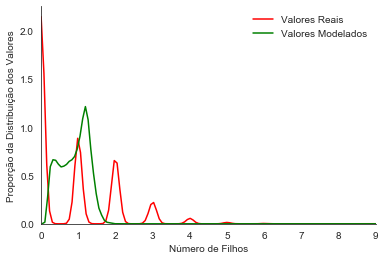

In [ ]:
## plotando as distribuicoes
sns.set_style(style="white")
fig, ax = plt.subplots(figsize = (6,4))

# plottanndo as curvas
sns.distplot(dfpft['nf'], hist = False, color = 'r', label = 'Valores Reais', bins = 1)
sns.distplot(yhat, hist = False, color = 'g', label = 'Valores Modelados', bins = 1)
## deixando o gráfico bonitinho
sns.despine()
ax.legend(loc='upper right', frameon = False)
## labels dos eixos
ax.set_xlabel("Número de Filhos", fontname = "Arial")
ax.set_ylabel("Proporção da Distribuição dos Valores", fontname = "Arial")
ax.set_xlim(0,9)
#plt.savefig('dist_filhos.png', dpi = 300)